In [1]:
!pip uninstall --yes --quiet osqp
!pip install scikit-survival

  Using cached osqp-0.6.2.post0-cp38-cp38-macosx_10_9_x86_64.whl (164 kB)


In [2]:
from typing import Any, Dict, Iterable, Sequence, Tuple, Optional, Union
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored
import tensorflow as tf
from tensorflow.keras.datasets import mnist

print("Using Tensorflow:", tf.__version__)

Using Tensorflow: 2.4.1


In [3]:
# Constants for development
FILESTOLOAD = 2888 # 2888 is all of them
imdim_from_preprocessing = 256 # must match opt.ImageSize in image preprocessing configuration files
imdim_for_network = 256
random_seed = 16

# Path to CSVs that connect patient id to slices and rfs label
zero_info_path = "/Users/katyscott/Documents/ICC/Data/Labels/" + str(imdim_from_preprocessing) +"/RFS_all_tumors_zero.csv"
zero_image_path = '/Users/katyscott/Documents/ICC/Data/Images/Tumors/' + str(imdim_from_preprocessing) + '/Zero/'

# Reading in info for zero background images
info = pd.read_csv(zero_info_path)
image_fnames = np.asarray(info.iloc[:, 0])
pat_num = np.asarray(info.iloc[:, 1])
slice_num = np.asarray(info.iloc[:, 2])
rfs_event = np.asarray(info.iloc[:, 3])
rfs_time = np.asarray(info.iloc[:, 4])

print(rfs_event.shape)
print(rfs_time[1])

(2888,)
0.6


100%|██████████| 2888/2888 [23:12<00:00,  2.07it/s]


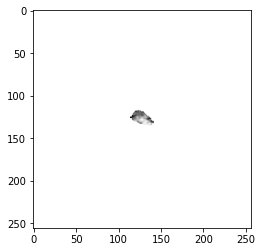

In [4]:
from tqdm import tqdm
from skimage.transform import resize

images = np.empty((1,imdim_for_network,imdim_for_network))
file_count = 0
for image_file in tqdm(image_fnames):
    if file_count >= FILESTOLOAD:
        break
    else:
        file_count += 1
    #     print("Loading: ", image_file)
        # Load in file as an numpy array
        img = np.fromfile(zero_image_path + image_file)
        # Reshape image from 1D to 2D array - need to nothardcode this, square root?
        img_2D = np.reshape(img, (imdim_from_preprocessing,imdim_from_preprocessing))
        # Scale image to this dimension, smooth image with Gaussian filter, pads with the reflection of the vector
        # mirrored on the first and last values of the vector along each axis.
        img_final = resize(img_2D, (imdim_for_network, imdim_for_network), anti_aliasing=True, mode='reflect')
        # Not sure this next line is working, want an array with all the images as their own array in it
        img_final_3D = np.reshape(img_final, (1,) + img_final.shape)
        images = np.append(images, img_final_3D, axis=0)

images = np.delete(images, 0, axis=0)
# Confirming images loaded in properly
plt.imshow(images[0], cmap='Greys')

In [9]:
FILESTOLOAD = 15

In [10]:
from patient_data_split import pat_train_test_split
# Training and testing split
split = 0.8
train_slice_indices, test_slice_indices = pat_train_test_split(pat_num[:FILESTOLOAD], rfs_event[:FILESTOLOAD], split, random_seed)

train_slices = images[train_slice_indices,:,:]#[:][:]
train_slices = train_slices.squeeze() # Remove first dim of size 1

train_time = rfs_time[train_slice_indices]
train_event = rfs_event[train_slice_indices]
print("Training set: ", train_slices.shape)
print("Training time labels: ", train_time.shape)
print("Training event labels: ", train_event.shape)

test_slices = images[test_slice_indices,:,:]
test_slices = test_slices.squeeze() # Remove first dim of size 1

test_time = rfs_time[test_slice_indices]
test_event = rfs_event[test_slice_indices]
print("Testing set: ", test_slices.shape)
print("Testing time labels: ", test_time.shape)
print("Testing event labels: ", test_event.shape)

Training set:  (12, 256, 256)
Training time labels:  (12,)
Training event labels:  (12,)
Testing set:  (3, 256, 256)
Testing time labels:  (3,)
Testing event labels:  (3,)


In [ ]:
# Convert rfs_event from numeric to boolean for use in sksurv
b_rfs_event = np.array(rfs_event, dtype=bool)
# Creating structured array for kaplan_meier_estimator
rfs_type = np.dtype([('Status','bool'), ('Time', 'f')])
rfs = np.empty(len(rfs_event),dtype=rfs_type)
rfs['Status'] = b_rfs_event
rfs['Time'] = rfs_time

rfs_train = rfs[train_slice_indices]
rfs_test = rfs[test_slice_indices]

train_1D = np.reshape(train_slices, (train_slices.shape[0], train_slices.shape[1]*train_slices.shape[2]))
test_1D = np.reshape(test_slices, (test_slices.shape[0], test_slices.shape[1]*test_slices.shape[2]))

print(train_1D.shape)
print(rfs_train.shape)
estimator = CoxPHSurvivalAnalysis().fit(train_1D, rfs_train)

risk_score = estimator.predict(train_1D)

# score = (train_1D, rfs_train)

# print(risk_score[1])

(12, 65536)
(12,)


Classes 0 and 5 (dotted lines) correspond to risk group 3, which has the highest risk score. The corresponding survival functions drop most quickly, which is exactly what we wanted. On the other end of the spectrum are classes 2 and 8 (solid lines) belonging to risk group 0 with the lowest risk.

## Evaluating Predictions

One important aspect for survival analysis is that both the training data and the test data are subject to censoring, because we are unable to observe the exact time of an event no matter how the data was split. Therefore, performance measures need to account for censoring. The most widely used performance measure is Harrell's concordance index. Given a set of (predicted) risk scores and observed times, it checks whether the ordering by risk scores is concordant with the ordering by actual survival time. While Harrell's concordance index is widely used, it has its flaws, in particular when data is highly censored. Please refer to my [previous post on evaluating survival models](https://k-d-w.org/blog/111/evaluating-survival-models) for more details.

We can take the risk score from which we generated survival times to check how good a model would perform if we knew the actual risk score.

In [11]:
# cindex = concordance_index_censored(event_test, time_test, risk_scores[y_train.shape[0]:])

# print(f"Concordance index on test data with actual risk scores: {cindex[0]:.3f}")

NameError: name 'event_test' is not defined

Surprisingly, we do not obtain a perfect result of 1.0. The reason for this is that generated survival times are randomly distributed based on risk scores and not deterministic functions of the risk score. Therefore, any model we will train on this data should not be able to exceed this performance value.

## Cox's Proportional Hazards Model

By far the most widely used model to learn from censored survival data, is
[Cox's proportional hazards model](https://scholar.google.com/scholar?cluster=17981786408695305487) model.
It models the hazard function $h(t_i)$
of the $i$-th subject, conditional on the feature vector $\mathbf{x}_i \in \mathbb{R}^p$,
as the product of an unspecified baseline hazard function $h_0$ (more on that later) and an
exponential function of the linear model $\mathbf{x}_i^\top \mathbf{\beta}$:
$$
h(t | x_{i1}, \ldots, x_{ip}) = h_0(t) \exp \left( \sum_{j=1}^p x_{ij} \beta_j \right)
\Leftrightarrow
\log \frac{h(t | \mathbf{x}_i)}{h_0 (t)} =  \mathbf{x}_i^\top \mathbf{\beta} ,
$$
where $\mathbf{\beta} \in \mathbb{R}^p$ are the coefficients associated with each of the
$p$ features, and no intercept term is included in the model.
The key is that the hazard function is split into two parts: the baseline hazard function $h_0$ only depends on the time $t$, whereas the exponential is independent of time and only depends on the covariates $\mathbf{x}_i$.

Cox's proportional hazards model is fitted by maximizing the partial likelihood function, which is based on the probability that the $i$-th individual experiences
an event at time $t_i$, given that there is one event at time point $t_i$.
As we will see, by specifying the hazard function as above, the baseline hazard function $h_0$
can be eliminated and does not need be defined for finding the coefficients $\mathbf{\beta}$.
Let $\mathcal{R}_i = \{ j\,|\,y_j \geq y_i \}$
be the risk set, i.e., the set of subjects who remained event-free shortly before time point $y_i$,
and $I(\cdot)$ the indicator function, then we have

$$
\begin{split}
&P(\text{subject experiences event at $y_i$} \mid \text{one event at $y_i$}) \\
=& \frac{P(\text{subject experiences event at $y_i$} \mid \text{event-free up to $y_i$})}
{P (\text{one event at $y_i$} \mid \text{event-free up to $y_i$})} \\
=& \frac{h(y_i | \mathbf{x}_i)}{ \sum_{j=1}^n I(y_j \geq y_i) h(y_j | \mathbf{x}_j) } \\
=& \frac{h_0(y_i) \exp(\mathbf{x}_i^\top \mathbf{\beta})}
{ \sum_{j=1}^n I(y_j \geq y_i) h_0(y_j) \exp(\mathbf{x}_j^\top \mathbf{\beta}) } \\
=& \frac{\exp( \mathbf{x}_i^\top \beta)}{\sum_{j \in \mathcal{R}_i} \exp( \mathbf{x}_j^\top \beta)} .
\end{split}
$$

By multiplying the conditional probability from above for all patients who experienced an event, and taking the logarithm, we obtain the *partial likelihood function*:

$$
\widehat{\mathbf{\beta}} = \arg\max_{\mathbf{\beta}}~
\log\,PL(\mathbf{\beta}) = \sum_{i=1}^n \delta_i \left[ \mathbf{x}_i^\top \mathbf{\beta}
- \log \left( \sum_{j \in \mathcal{R}_i} \exp( \mathbf{x}_j^\top \mathbf{\beta}) \right) \right] .
$$


## Non-linear Survival Analysis with Neural Networks

Cox's proportional hazards model as described above is a linear model, i.e., the predicted risk score is a linear combination of features. However, the model can easily be extended to the non-linear case by just replacing the linear predictor with the output of a neural network with parameters $\mathbf{\Theta}$.

![image](data:image/svg+xml,%3C%3Fxml%20version%3D%221.0%22%20encoding%3D%22UTF-8%22%3F%3E%0A%3Csvg%20xmlns%3D%22http%3A//www.w3.org/2000/svg%22%20xmlns%3Axlink%3D%22http%3A//www.w3.org/1999/xlink%22%20width%3D%22323pt%22%20height%3D%22162pt%22%20viewBox%3D%220%200%20323%20162%22%20version%3D%221.1%22%3E%0A%3Cdefs%3E%0A%3Cg%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%207.109375%200%20L%207.109375%20-8.296875%20L%206.078125%20-8.296875%20L%206.078125%20-4.671875%20L%202.109375%20-4.671875%20L%202.109375%20-8.296875%20L%201.078125%20-8.296875%20L%201.078125%200%20L%202.109375%200%20L%202.109375%20-3.953125%20L%206.078125%20-3.953125%20L%206.078125%200%20Z%20M%207.109375%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%201.8125%200%20L%201.8125%20-5.3125%20L%200.9375%20-5.3125%20L%200.9375%200%20Z%20M%201.890625%20-6.796875%20L%201.890625%20-7.8125%20L%200.859375%20-7.8125%20L%200.859375%20-6.796875%20Z%20M%201.890625%20-6.796875%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-3%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.0625%200%20L%205.0625%20-8.296875%20L%204.171875%20-8.296875%20L%204.171875%20-4.8125%20C%203.625%20-5.265625%203%20-5.421875%202.484375%20-5.421875%20C%201.34375%20-5.421875%200.421875%20-4.203125%200.421875%20-2.65625%20C%200.421875%20-1.109375%201.296875%200.125%202.4375%200.125%20C%202.875%200.125%203.546875%20-0.03125%204.140625%20-0.609375%20L%204.140625%200%20Z%20M%204.140625%20-1.40625%20C%203.859375%20-0.890625%203.4375%20-0.59375%202.921875%20-0.59375%20C%202.1875%20-0.59375%201.328125%20-1.15625%201.328125%20-2.640625%20C%201.328125%20-4.234375%202.34375%20-4.703125%203.03125%20-4.703125%20C%203.5%20-4.703125%203.890625%20-4.46875%204.140625%20-4.078125%20Z%20M%204.140625%20-1.40625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-4%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.859375%20-2.6875%20C%204.859375%20-3.203125%204.8125%20-3.9375%204.4375%20-4.5625%20C%203.9375%20-5.390625%203.109375%20-5.484375%202.765625%20-5.484375%20C%201.46875%20-5.484375%200.390625%20-4.25%200.390625%20-2.6875%20C%200.390625%20-1.109375%201.546875%200.125%202.921875%200.125%20C%203.484375%200.125%204.140625%20-0.03125%204.796875%20-0.515625%20C%204.796875%20-0.5625%204.75%20-0.953125%204.75%20-0.953125%20C%204.75%20-0.953125%204.71875%20-1.234375%204.71875%20-1.28125%20C%204.015625%20-0.6875%203.3125%20-0.59375%202.953125%20-0.59375%20C%202.03125%20-0.59375%201.25%20-1.421875%201.21875%20-2.6875%20Z%20M%204.15625%20-3.328125%20L%201.296875%20-3.328125%20C%201.5%20-4.140625%202.0625%20-4.765625%202.765625%20-4.765625%20C%203.125%20-4.765625%203.953125%20-4.609375%204.15625%20-3.328125%20Z%20M%204.15625%20-3.328125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-5%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.0625%200%20L%205.0625%20-3.59375%20C%205.0625%20-4.328125%204.90625%20-5.421875%203.46875%20-5.421875%20C%202.796875%20-5.421875%202.21875%20-5.125%201.765625%20-4.546875%20L%201.765625%20-5.359375%20L%200.921875%20-5.359375%20L%200.921875%200%20L%201.828125%200%20L%201.828125%20-2.96875%20C%201.828125%20-3.71875%202.109375%20-4.703125%203.015625%20-4.703125%20C%204.125%20-4.703125%204.15625%20-3.9375%204.15625%20-3.515625%20L%204.15625%200%20Z%20M%205.0625%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-6%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%201.8125%200%20L%201.8125%20-8.296875%20L%200.9375%20-8.296875%20L%200.9375%200%20Z%20M%201.8125%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-7%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.796875%200%20L%204.796875%20-3.5%20C%204.796875%20-4.65625%203.96875%20-5.484375%202.859375%20-5.484375%20C%202.140625%20-5.484375%201.609375%20-5.3125%201.015625%20-4.984375%20L%201.09375%20-4.203125%20C%201.609375%20-4.578125%202.15625%20-4.796875%202.859375%20-4.796875%20C%203.40625%20-4.796875%203.890625%20-4.34375%203.890625%20-3.484375%20L%203.890625%20-2.984375%20C%203.34375%20-2.96875%202.625%20-2.921875%201.90625%20-2.6875%20C%201.109375%20-2.421875%200.640625%20-1.96875%200.640625%20-1.375%20C%200.640625%20-0.84375%200.953125%200.125%201.96875%200.125%20C%202.625%200.125%203.46875%20-0.078125%203.90625%20-0.4375%20L%203.90625%200%20Z%20M%203.890625%20-1.609375%20C%203.890625%20-1.359375%203.890625%20-1.078125%203.484375%20-0.84375%20C%203.171875%20-0.640625%202.765625%20-0.59375%202.578125%20-0.59375%20C%201.9375%20-0.59375%201.5%20-0.9375%201.5%20-1.390625%20C%201.5%20-2.203125%203.15625%20-2.375%203.890625%20-2.375%20Z%20M%203.890625%20-1.609375%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-8%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.171875%20-5.3125%20L%204.28125%20-5.3125%20C%203.734375%20-3.890625%202.8125%20-1.546875%202.765625%20-0.6875%20L%202.75%20-0.6875%20C%202.6875%20-1.40625%202.0625%20-2.96875%201.953125%20-3.21875%20L%201.109375%20-5.3125%20L%200.171875%20-5.3125%20L%202.390625%200%20L%201.96875%201.09375%20C%201.703125%201.6875%201.53125%201.75%201.3125%201.75%20C%201.140625%201.75%200.765625%201.703125%200.390625%201.5625%20L%200.46875%202.34375%20C%200.53125%202.359375%200.9375%202.4375%201.3125%202.4375%20C%201.609375%202.4375%202.15625%202.4375%202.671875%201.125%20Z%20M%205.171875%20-5.3125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-9%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%203.796875%20-4.625%20L%203.796875%20-5.421875%20C%202.71875%20-5.421875%202.078125%20-4.78125%201.75%20-4.3125%20L%201.75%20-5.359375%20L%200.9375%20-5.359375%20L%200.9375%200%20L%201.8125%200%20L%201.8125%20-2.625%20C%201.8125%20-3.828125%202.71875%20-4.609375%203.796875%20-4.625%20Z%20M%203.796875%20-4.625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-10%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%202.109375%200%20L%202.109375%20-8.296875%20L%201.078125%20-8.296875%20L%201.078125%200%20Z%20M%202.109375%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-11%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.5625%20-2.671875%20C%205.5625%20-4.109375%204.8125%20-5.421875%203.6875%20-5.421875%20C%203.203125%20-5.421875%202.4375%20-5.265625%201.8125%20-4.75%20L%201.8125%20-5.3125%20L%200.9375%20-5.3125%20L%200.9375%202.3125%20L%201.84375%202.3125%20L%201.84375%20-0.53125%20C%202.25%20-0.171875%202.75%200.125%203.390625%200.125%20C%204.546875%200.125%205.5625%20-1.046875%205.5625%20-2.671875%20Z%20M%204.65625%20-2.65625%20C%204.65625%20-1.453125%203.84375%20-0.59375%202.953125%20-0.59375%20C%202.625%20-0.59375%202.390625%20-0.71875%202.171875%20-0.890625%20C%201.875%20-1.140625%201.84375%20-1.359375%201.84375%20-1.546875%20L%201.84375%20-4.015625%20C%202.109375%20-4.421875%202.5625%20-4.6875%203.0625%20-4.6875%20C%203.9375%20-4.6875%204.65625%20-3.796875%204.65625%20-2.65625%20Z%20M%204.65625%20-2.65625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-12%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.0625%200%20L%205.0625%20-5.3125%20L%204.15625%20-5.3125%20L%204.15625%20-1.890625%20C%204.15625%20-0.984375%203.53125%20-0.53125%202.75%20-0.53125%20C%201.90625%20-0.53125%201.828125%20-0.84375%201.828125%20-1.375%20L%201.828125%20-5.3125%20L%200.921875%20-5.3125%20L%200.921875%20-1.328125%20C%200.921875%20-0.46875%201.1875%200.125%202.171875%200.125%20C%202.515625%200.125%203.453125%200.0625%204.1875%20-0.59375%20L%204.1875%200%20Z%20M%205.0625%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-13%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%203.890625%20-0.34375%20L%203.71875%20-1.046875%20C%203.296875%20-0.671875%202.859375%20-0.625%202.640625%20-0.625%20C%202.109375%20-0.625%202.046875%20-1.1875%202.046875%20-1.609375%20L%202.046875%20-4.609375%20L%203.6875%20-4.609375%20L%203.6875%20-5.3125%20L%202.046875%20-5.3125%20L%202.046875%20-6.828125%20L%201.21875%20-6.828125%20L%201.21875%20-5.3125%20L%200.21875%20-5.3125%20L%200.21875%20-4.609375%20L%201.1875%20-4.609375%20L%201.1875%20-1.40625%20C%201.1875%20-0.703125%201.34375%200.125%202.171875%200.125%20C%202.96875%200.125%203.53125%20-0.15625%203.890625%20-0.34375%20Z%20M%203.890625%20-0.34375%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-14%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%207.96875%20-4.125%20C%207.96875%20-6.65625%206.25%20-8.546875%204.3125%20-8.546875%20C%202.328125%20-8.546875%200.640625%20-6.625%200.640625%20-4.125%20C%200.640625%20-1.609375%202.375%200.25%204.296875%200.25%20C%206.28125%200.25%207.96875%20-1.625%207.96875%20-4.125%20Z%20M%206.9375%20-4.296875%20C%206.9375%20-1.953125%205.65625%20-0.5%204.3125%20-0.5%20C%202.921875%20-0.5%201.671875%20-2%201.671875%20-4.296875%20C%201.671875%20-6.5%202.96875%20-7.8125%204.296875%20-7.8125%20C%205.671875%20-7.8125%206.9375%20-6.46875%206.9375%20-4.296875%20Z%20M%206.9375%20-4.296875%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-15%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%206.875%20-0.53125%20L%206.796875%20-1.375%20C%206.484375%20-1.140625%206.125%20-0.890625%205.734375%20-0.765625%20C%205.359375%20-0.640625%204.953125%20-0.625%204.546875%20-0.625%20C%203.78125%20-0.625%203.078125%20-1.046875%202.609375%20-1.65625%20C%202.0625%20-2.359375%201.8125%20-3.25%201.8125%20-4.140625%20C%201.8125%20-5.046875%202.0625%20-5.9375%202.609375%20-6.640625%20C%203.078125%20-7.25%203.78125%20-7.671875%204.546875%20-7.671875%20C%204.90625%20-7.671875%205.265625%20-7.640625%205.609375%20-7.53125%20C%205.953125%20-7.40625%206.28125%20-7.234375%206.578125%20-7.015625%20L%206.75%20-8.015625%20C%206.390625%20-8.15625%206.03125%20-8.265625%205.671875%20-8.328125%20C%205.296875%20-8.40625%204.90625%20-8.421875%204.546875%20-8.421875%20C%203.515625%20-8.421875%202.5625%20-7.953125%201.890625%20-7.171875%20C%201.140625%20-6.34375%200.78125%20-5.265625%200.78125%20-4.140625%20C%200.78125%20-3.046875%201.140625%20-1.953125%201.890625%20-1.125%20C%202.5625%20-0.359375%203.515625%200.125%204.546875%200.125%20C%204.953125%200.125%205.359375%200.109375%205.765625%200%20C%206.171875%20-0.125%206.53125%20-0.328125%206.875%20-0.53125%20Z%20M%206.875%20-0.53125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-16%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.484375%20-2.625%20C%205.484375%20-4.25%204.296875%20-5.484375%202.921875%20-5.484375%20C%201.515625%20-5.484375%200.359375%20-4.21875%200.359375%20-2.625%20C%200.359375%20-1.0625%201.546875%200.125%202.921875%200.125%20C%204.328125%200.125%205.484375%20-1.09375%205.484375%20-2.625%20Z%20M%204.578125%20-2.75%20C%204.578125%20-1.28125%203.734375%20-0.625%202.921875%20-0.625%20C%202.0625%20-0.625%201.265625%20-1.34375%201.265625%20-2.75%20C%201.265625%20-4.203125%202.15625%20-4.765625%202.921875%20-4.765625%20C%203.734375%20-4.765625%204.578125%20-4.140625%204.578125%20-2.75%20Z%20M%204.578125%20-2.75%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-17%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.34375%200%20L%203.03125%20-2.734375%20L%205.15625%20-5.3125%20L%204.140625%20-5.3125%20L%202.640625%20-3.375%20L%201.078125%20-5.3125%20L%200.0625%20-5.3125%20L%202.234375%20-2.734375%20L%200%200%20L%200.984375%200%20L%202.640625%20-2.21875%20L%204.34375%200%20Z%20M%205.34375%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-18%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%206.796875%20-5.875%20C%206.796875%20-7.140625%205.625%20-8.296875%204%20-8.296875%20L%201.09375%20-8.296875%20L%201.09375%200%20L%202.109375%200%20L%202.109375%20-3.453125%20L%204%20-3.453125%20C%205.65625%20-3.453125%206.796875%20-4.640625%206.796875%20-5.875%20Z%20M%205.84375%20-5.890625%20C%205.84375%20-4.953125%205.109375%20-4.140625%203.75%20-4.140625%20L%202.09375%20-4.140625%20L%202.09375%20-7.625%20L%203.75%20-7.625%20C%205.15625%20-7.625%205.84375%20-6.796875%205.84375%20-5.890625%20Z%20M%205.84375%20-5.890625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph0-19%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.203125%20-1.515625%20C%204.203125%20-2.125%203.84375%20-2.515625%203.796875%20-2.5625%20C%203.34375%20-3.03125%202.984375%20-3.09375%202.265625%20-3.234375%20C%201.828125%20-3.328125%201.21875%20-3.4375%201.21875%20-4.046875%20C%201.21875%20-4.78125%202.0625%20-4.78125%202.21875%20-4.78125%20C%202.84375%20-4.78125%203.34375%20-4.640625%203.875%20-4.34375%20L%204.015625%20-5.109375%20C%203.25%20-5.46875%202.609375%20-5.484375%202.328125%20-5.484375%20C%202.0625%20-5.484375%200.390625%20-5.484375%200.390625%20-3.9375%20C%200.390625%20-3.40625%200.6875%20-3.046875%200.859375%20-2.875%20C%201.296875%20-2.515625%201.59375%20-2.453125%202.296875%20-2.3125%20C%202.6875%20-2.21875%203.375%20-2.078125%203.375%20-1.453125%20C%203.375%20-0.625%202.453125%20-0.625%202.28125%20-0.625%20C%201.8125%20-0.625%201.109375%20-0.75%200.46875%20-1.21875%20L%200.328125%20-0.40625%20C%200.375%20-0.375%201.1875%200.125%202.296875%200.125%20C%203.84375%200.125%204.203125%20-0.8125%204.203125%20-1.515625%20Z%20M%204.203125%20-1.515625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.671875%20-1.0625%20L%205.671875%20-1.734375%20L%205.40625%20-1.734375%20L%205.40625%20-1.0625%20C%205.40625%20-0.375%205.109375%20-0.28125%204.953125%20-0.28125%20C%204.5%20-0.28125%204.5%20-0.921875%204.5%20-1.09375%20L%204.5%20-3.1875%20C%204.5%20-3.84375%204.5%20-4.3125%203.96875%20-4.78125%20C%203.546875%20-5.15625%203.015625%20-5.328125%202.484375%20-5.328125%20C%201.5%20-5.328125%200.75%20-4.6875%200.75%20-3.90625%20C%200.75%20-3.5625%200.984375%20-3.390625%201.25%20-3.390625%20C%201.546875%20-3.390625%201.75%20-3.59375%201.75%20-3.890625%20C%201.75%20-4.375%201.3125%20-4.375%201.140625%20-4.375%20C%201.40625%20-4.875%201.984375%20-5.09375%202.46875%20-5.09375%20C%203.015625%20-5.09375%203.71875%20-4.640625%203.71875%20-3.5625%20L%203.71875%20-3.078125%20C%201.3125%20-3.046875%200.40625%20-2.046875%200.40625%20-1.125%20C%200.40625%20-0.171875%201.5%200.125%202.234375%200.125%20C%203.03125%200.125%203.5625%20-0.359375%203.796875%20-0.9375%20C%203.84375%20-0.375%204.203125%200.0625%204.71875%200.0625%20C%204.96875%200.0625%205.671875%20-0.109375%205.671875%20-1.0625%20Z%20M%203.71875%20-1.6875%20C%203.71875%20-0.515625%202.84375%20-0.125%202.328125%20-0.125%20C%201.75%20-0.125%201.25%20-0.546875%201.25%20-1.125%20C%201.25%20-2.703125%203.28125%20-2.84375%203.71875%20-2.875%20Z%20M%203.71875%20-1.6875%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.21875%20-4.578125%20C%204.21875%20-4.9375%203.890625%20-5.265625%203.375%20-5.265625%20C%202.359375%20-5.265625%202.015625%20-4.171875%201.953125%20-3.9375%20L%201.9375%20-3.9375%20L%201.9375%20-5.265625%20L%200.328125%20-5.140625%20L%200.328125%20-4.796875%20C%201.140625%20-4.796875%201.25%20-4.703125%201.25%20-4.125%20L%201.25%20-0.890625%20C%201.25%20-0.34375%201.109375%20-0.34375%200.328125%20-0.34375%20L%200.328125%200%20C%200.671875%20-0.03125%201.328125%20-0.03125%201.6875%20-0.03125%20C%202.015625%20-0.03125%202.859375%20-0.03125%203.125%200%20L%203.125%20-0.34375%20L%202.890625%20-0.34375%20C%202.015625%20-0.34375%202%20-0.484375%202%20-0.90625%20L%202%20-2.78125%20C%202%20-3.9375%202.46875%20-5.03125%203.390625%20-5.03125%20C%203.484375%20-5.03125%203.515625%20-5.03125%203.5625%20-5.015625%20C%203.46875%20-4.96875%203.28125%20-4.90625%203.28125%20-4.578125%20C%203.28125%20-4.234375%203.546875%20-4.09375%203.734375%20-4.09375%20C%203.984375%20-4.09375%204.21875%20-4.25%204.21875%20-4.578125%20Z%20M%204.21875%20-4.578125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-3%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.671875%20-4.859375%20C%205.671875%20-5.0625%205.515625%20-5.40625%205.09375%20-5.40625%20C%204.46875%20-5.40625%204%20-5.015625%203.84375%20-4.84375%20C%203.484375%20-5.109375%203.0625%20-5.265625%202.609375%20-5.265625%20C%201.53125%20-5.265625%200.734375%20-4.453125%200.734375%20-3.53125%20C%200.734375%20-2.859375%201.140625%20-2.421875%201.265625%20-2.3125%20C%201.125%20-2.125%200.90625%20-1.78125%200.90625%20-1.3125%20C%200.90625%20-0.625%201.328125%20-0.328125%201.421875%20-0.265625%20C%200.875%20-0.109375%200.328125%200.328125%200.328125%200.9375%20C%200.328125%201.765625%201.453125%202.453125%202.921875%202.453125%20C%204.34375%202.453125%205.515625%201.8125%205.515625%200.921875%20C%205.515625%200.625%205.4375%20-0.078125%204.71875%20-0.453125%20C%204.109375%20-0.765625%203.515625%20-0.765625%202.484375%20-0.765625%20C%201.75%20-0.765625%201.671875%20-0.765625%201.453125%20-0.984375%20C%201.34375%20-1.109375%201.234375%20-1.34375%201.234375%20-1.59375%20C%201.234375%20-1.796875%201.296875%20-2%201.421875%20-2.15625%20C%201.984375%20-1.796875%202.46875%20-1.796875%202.59375%20-1.796875%20C%203.671875%20-1.796875%204.46875%20-2.609375%204.46875%20-3.53125%20C%204.46875%20-3.84375%204.375%20-4.296875%204%20-4.6875%20C%204.453125%20-5.15625%205.015625%20-5.15625%205.078125%20-5.15625%20C%205.125%20-5.15625%205.1875%20-5.15625%205.234375%20-5.140625%20C%205.109375%20-5.09375%205.0625%20-4.96875%205.0625%20-4.84375%20C%205.0625%20-4.671875%205.171875%20-4.53125%205.359375%20-4.53125%20C%205.46875%20-4.53125%205.671875%20-4.59375%205.671875%20-4.859375%20Z%20M%203.640625%20-3.53125%20C%203.640625%20-3.328125%203.640625%20-2.828125%203.4375%20-2.515625%20C%203.21875%20-2.15625%202.859375%20-2.046875%202.609375%20-2.046875%20C%201.546875%20-2.046875%201.546875%20-3.25%201.546875%20-3.53125%20C%201.546875%20-3.734375%201.546875%20-4.234375%201.75%20-4.546875%20C%201.984375%20-4.90625%202.34375%20-5.015625%202.59375%20-5.015625%20C%203.640625%20-5.015625%203.640625%20-3.8125%203.640625%20-3.53125%20Z%20M%204.9375%200.9375%20C%204.9375%201.640625%204.03125%202.203125%202.921875%202.203125%20C%201.78125%202.203125%200.90625%201.609375%200.90625%200.9375%20C%200.90625%200.84375%200.9375%200.375%201.390625%200.0625%20C%201.65625%20-0.109375%201.75%20-0.109375%202.59375%20-0.109375%20C%203.578125%20-0.109375%204.9375%20-0.109375%204.9375%200.9375%20Z%20M%204.9375%200.9375%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-4%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%209.484375%200%20L%209.484375%20-0.34375%20C%208.875%20-0.34375%208.578125%20-0.34375%208.578125%20-0.703125%20L%208.578125%20-2.90625%20C%208.578125%20-4.015625%208.578125%20-4.34375%208.296875%20-4.734375%20C%207.953125%20-5.203125%207.390625%20-5.265625%206.984375%20-5.265625%20C%205.984375%20-5.265625%205.484375%20-4.546875%205.296875%20-4.09375%20C%205.125%20-5.015625%204.484375%20-5.265625%203.734375%20-5.265625%20C%202.5625%20-5.265625%202.109375%20-4.28125%202.015625%20-4.046875%20L%202.015625%20-5.265625%20L%200.375%20-5.140625%20L%200.375%20-4.796875%20C%201.1875%20-4.796875%201.296875%20-4.703125%201.296875%20-4.125%20L%201.296875%20-0.890625%20C%201.296875%20-0.34375%201.15625%20-0.34375%200.375%20-0.34375%20L%200.375%200%20C%200.6875%20-0.03125%201.34375%20-0.03125%201.671875%20-0.03125%20C%202.015625%20-0.03125%202.671875%20-0.03125%202.96875%200%20L%202.96875%20-0.34375%20C%202.21875%20-0.34375%202.0625%20-0.34375%202.0625%20-0.890625%20L%202.0625%20-3.109375%20C%202.0625%20-4.359375%202.890625%20-5.03125%203.640625%20-5.03125%20C%204.375%20-5.03125%204.546875%20-4.421875%204.546875%20-3.6875%20L%204.546875%20-0.890625%20C%204.546875%20-0.34375%204.40625%20-0.34375%203.640625%20-0.34375%20L%203.640625%200%20C%203.9375%20-0.03125%204.59375%20-0.03125%204.921875%20-0.03125%20C%205.265625%20-0.03125%205.921875%20-0.03125%206.234375%200%20L%206.234375%20-0.34375%20C%205.46875%20-0.34375%205.3125%20-0.34375%205.3125%20-0.890625%20L%205.3125%20-3.109375%20C%205.3125%20-4.359375%206.140625%20-5.03125%206.890625%20-5.03125%20C%207.625%20-5.03125%207.796875%20-4.421875%207.796875%20-3.6875%20L%207.796875%20-0.890625%20C%207.796875%20-0.34375%207.65625%20-0.34375%206.890625%20-0.34375%20L%206.890625%200%20C%207.203125%20-0.03125%207.84375%20-0.03125%208.171875%20-0.03125%20C%208.515625%20-0.03125%209.171875%20-0.03125%209.484375%200%20Z%20M%209.484375%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-5%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%206.046875%200%20L%206.046875%20-0.34375%20C%205.421875%20-0.34375%205.203125%20-0.375%204.90625%20-0.75%20L%203.34375%20-2.828125%20C%203.6875%20-3.28125%204.203125%20-3.921875%204.421875%20-4.171875%20C%204.90625%20-4.71875%205.46875%20-4.8125%205.859375%20-4.8125%20L%205.859375%20-5.15625%20C%205.34375%20-5.125%205.3125%20-5.125%204.859375%20-5.125%20L%203.78125%20-5.15625%20L%203.78125%20-4.8125%20C%203.9375%20-4.78125%204.125%20-4.703125%204.125%20-4.4375%20C%204.125%20-4.234375%204.015625%20-4.09375%203.9375%20-4%20L%203.171875%20-3.03125%20L%202.25%20-4.265625%20C%202.21875%20-4.3125%202.140625%20-4.421875%202.140625%20-4.5%20C%202.140625%20-4.578125%202.203125%20-4.796875%202.5625%20-4.8125%20L%202.5625%20-5.15625%20C%202.265625%20-5.125%201.65625%20-5.125%201.328125%20-5.125%20L%200.171875%20-5.15625%20L%200.171875%20-4.8125%20C%200.78125%20-4.8125%201.015625%20-4.78125%201.265625%20-4.453125%20L%202.671875%20-2.625%20C%202.6875%20-2.609375%202.734375%20-2.53125%202.734375%20-2.5%20C%202.734375%20-2.46875%201.8125%20-1.296875%201.6875%20-1.140625%20C%201.15625%20-0.484375%200.640625%20-0.359375%200.125%20-0.34375%20L%200.125%200%20C%200.578125%20-0.03125%200.59375%20-0.03125%201.109375%20-0.03125%20L%202.1875%200%20L%202.1875%20-0.34375%20C%201.90625%20-0.375%201.859375%20-0.5625%201.859375%20-0.734375%20C%201.859375%20-0.921875%201.9375%20-1.015625%202.0625%20-1.171875%20L%202.921875%20-2.28125%20L%203.890625%20-1%20C%204.09375%20-0.734375%204.09375%20-0.71875%204.09375%20-0.640625%20C%204.09375%20-0.546875%204%20-0.359375%203.6875%20-0.34375%20L%203.6875%200%20C%204%20-0.03125%204.578125%20-0.03125%204.90625%20-0.03125%20Z%20M%206.046875%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-6%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%203.890625%202.90625%20C%203.890625%202.875%203.890625%202.84375%203.6875%202.640625%20C%202.484375%201.4375%201.8125%20-0.53125%201.8125%20-2.96875%20C%201.8125%20-5.296875%202.375%20-7.296875%203.765625%20-8.703125%20C%203.890625%20-8.8125%203.890625%20-8.828125%203.890625%20-8.875%20C%203.890625%20-8.9375%203.828125%20-8.96875%203.78125%20-8.96875%20C%203.625%20-8.96875%202.640625%20-8.109375%202.0625%20-6.9375%20C%201.453125%20-5.71875%201.171875%20-4.453125%201.171875%20-2.96875%20C%201.171875%20-1.90625%201.34375%20-0.484375%201.953125%200.78125%20C%202.671875%202.21875%203.640625%203%203.78125%203%20C%203.828125%203%203.890625%202.96875%203.890625%202.90625%20Z%20M%203.890625%202.90625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-7%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%203.375%20-2.96875%20C%203.375%20-3.890625%203.25%20-5.359375%202.578125%20-6.75%20C%201.875%20-8.1875%200.890625%20-8.96875%200.765625%20-8.96875%20C%200.71875%20-8.96875%200.65625%20-8.9375%200.65625%20-8.875%20C%200.65625%20-8.828125%200.65625%20-8.8125%200.859375%20-8.609375%20C%202.0625%20-7.40625%202.71875%20-5.421875%202.71875%20-2.984375%20C%202.71875%20-0.671875%202.15625%201.328125%200.78125%202.734375%20C%200.65625%202.84375%200.65625%202.875%200.65625%202.90625%20C%200.65625%202.96875%200.71875%203%200.765625%203%20C%200.921875%203%201.90625%202.140625%202.484375%200.96875%20C%203.09375%20-0.25%203.375%20-1.546875%203.375%20-2.96875%20Z%20M%203.375%20-2.96875%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-8%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%202.96875%200%20L%202.96875%20-0.34375%20C%202.203125%20-0.34375%202.0625%20-0.34375%202.0625%20-0.890625%20L%202.0625%20-8.296875%20L%200.390625%20-8.15625%20L%200.390625%20-7.8125%20C%201.203125%20-7.8125%201.296875%20-7.734375%201.296875%20-7.140625%20L%201.296875%20-0.890625%20C%201.296875%20-0.34375%201.171875%20-0.34375%200.390625%20-0.34375%20L%200.390625%200%20C%200.734375%20-0.03125%201.3125%20-0.03125%201.671875%20-0.03125%20C%202.03125%20-0.03125%202.625%20-0.03125%202.96875%200%20Z%20M%202.96875%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-9%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.484375%20-2.5625%20C%205.484375%20-4.09375%204.3125%20-5.328125%202.921875%20-5.328125%20C%201.5%20-5.328125%200.359375%20-4.0625%200.359375%20-2.5625%20C%200.359375%20-1.03125%201.546875%200.125%202.921875%200.125%20C%204.328125%200.125%205.484375%20-1.046875%205.484375%20-2.5625%20Z%20M%204.578125%20-2.671875%20C%204.578125%20-2.25%204.578125%20-1.5%204.265625%20-0.9375%20C%203.9375%20-0.375%203.375%20-0.140625%202.921875%20-0.140625%20C%202.484375%20-0.140625%201.953125%20-0.328125%201.609375%20-0.921875%20C%201.28125%20-1.453125%201.265625%20-2.15625%201.265625%20-2.671875%20C%201.265625%20-3.125%201.265625%20-3.84375%201.640625%20-4.390625%20C%201.96875%20-4.90625%202.5%20-5.09375%202.921875%20-5.09375%20C%203.375%20-5.09375%203.890625%20-4.875%204.203125%20-4.40625%20C%204.578125%20-3.859375%204.578125%20-3.109375%204.578125%20-2.671875%20Z%20M%204.578125%20-2.671875%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-10%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.859375%20-1.421875%20C%204.859375%20-1.5%204.8125%20-1.546875%204.734375%20-1.546875%20C%204.640625%20-1.546875%204.609375%20-1.484375%204.59375%20-1.421875%20C%204.28125%20-0.421875%203.484375%20-0.140625%202.96875%20-0.140625%20C%202.46875%20-0.140625%201.265625%20-0.484375%201.265625%20-2.546875%20L%201.265625%20-2.765625%20L%204.578125%20-2.765625%20C%204.84375%20-2.765625%204.859375%20-2.765625%204.859375%20-3%20C%204.859375%20-4.203125%204.21875%20-5.328125%202.765625%20-5.328125%20C%201.40625%20-5.328125%200.359375%20-4.09375%200.359375%20-2.625%20C%200.359375%20-1.046875%201.578125%200.125%202.90625%200.125%20C%204.328125%200.125%204.859375%20-1.171875%204.859375%20-1.421875%20Z%20M%204.125%20-3%20L%201.28125%20-3%20C%201.375%20-4.875%202.421875%20-5.09375%202.765625%20-5.09375%20C%204.046875%20-5.09375%204.109375%20-3.40625%204.125%20-3%20Z%20M%204.125%20-3%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph1-11%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%206.078125%20-2.578125%20C%206.078125%20-4.09375%204.953125%20-5.265625%203.640625%20-5.265625%20C%202.59375%20-5.265625%202.03125%20-4.515625%202%20-4.46875%20L%202%20-5.265625%20L%200.328125%20-5.140625%20L%200.328125%20-4.796875%20C%201.171875%20-4.796875%201.25%20-4.703125%201.25%20-4.1875%20L%201.25%201.4375%20C%201.25%201.96875%201.109375%201.96875%200.328125%201.96875%20L%200.328125%202.3125%20C%200.640625%202.296875%201.296875%202.296875%201.625%202.296875%20C%201.96875%202.296875%202.625%202.296875%202.921875%202.3125%20L%202.921875%201.96875%20C%202.15625%201.96875%202.015625%201.96875%202.015625%201.4375%20L%202.015625%20-0.640625%20C%202.234375%20-0.34375%202.71875%200.125%203.484375%200.125%20C%204.859375%200.125%206.078125%20-1.046875%206.078125%20-2.578125%20Z%20M%205.15625%20-2.578125%20C%205.15625%20-1.15625%204.34375%20-0.125%203.4375%20-0.125%20C%203.0625%20-0.125%202.71875%20-0.28125%202.46875%20-0.5%20C%202.203125%20-0.78125%202.015625%20-1.015625%202.015625%20-1.34375%20L%202.015625%20-3.8125%20C%202.015625%20-4.046875%202.015625%20-4.046875%202.15625%20-4.25%20C%202.515625%20-4.78125%203.09375%20-5.015625%203.546875%20-5.015625%20C%204.453125%20-5.015625%205.15625%20-3.921875%205.15625%20-2.578125%20Z%20M%205.15625%20-2.578125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph2-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph2-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%207.046875%20-2.703125%20C%207.046875%20-4.265625%205.953125%20-5.578125%203.796875%20-5.578125%20C%201.625%20-5.578125%200.546875%20-4.25%200.546875%20-2.703125%20C%200.546875%20-1.15625%201.640625%200.109375%203.796875%200.109375%20C%205.9375%200.109375%207.046875%20-1.15625%207.046875%20-2.703125%20Z%20M%205.875%20-2.703125%20C%205.875%20-1.859375%205.71875%20-1.34375%205.390625%20-0.921875%20C%205.078125%20-0.53125%204.515625%20-0.234375%203.796875%20-0.234375%20C%203.0625%20-0.234375%202.515625%20-0.53125%202.21875%20-0.90625%20C%201.875%20-1.328125%201.71875%20-1.859375%201.71875%20-2.703125%20C%201.71875%20-3.015625%201.71875%20-3.875%202.15625%20-4.484375%20C%202.625%20-5.09375%203.296875%20-5.25%203.796875%20-5.25%20C%204.25%20-5.25%204.96875%20-5.109375%205.453125%20-4.453125%20C%205.84375%20-3.875%205.875%20-3.078125%205.875%20-2.703125%20Z%20M%205.328125%20-1.953125%20L%205.328125%20-3.515625%20L%204.875%20-3.515625%20L%204.875%20-3.25%20L%202.703125%20-3.25%20L%202.703125%20-3.515625%20L%202.265625%20-3.515625%20L%202.265625%20-1.953125%20L%202.703125%20-1.953125%20L%202.703125%20-2.234375%20L%204.875%20-2.234375%20L%204.875%20-1.953125%20Z%20M%205.328125%20-1.953125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph3-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph3-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.875%20-1.140625%20C%204.875%20-1.21875%204.8125%20-1.25%204.75%20-1.25%20C%204.65625%20-1.25%204.640625%20-1.1875%204.625%20-1.109375%20C%204.4375%20-0.453125%204.09375%20-0.140625%203.796875%20-0.140625%20C%203.671875%20-0.140625%203.609375%20-0.21875%203.609375%20-0.40625%20C%203.609375%20-0.59375%203.671875%20-0.765625%203.75%20-0.96875%20C%203.859375%20-1.265625%204.21875%20-2.1875%204.21875%20-2.625%20C%204.21875%20-3.234375%203.796875%20-3.515625%203.234375%20-3.515625%20C%202.578125%20-3.515625%202.171875%20-3.125%201.9375%20-2.828125%20C%201.875%20-3.265625%201.53125%20-3.515625%201.125%20-3.515625%20C%200.84375%20-3.515625%200.640625%20-3.328125%200.515625%20-3.078125%20C%200.3125%20-2.703125%200.234375%20-2.296875%200.234375%20-2.296875%20C%200.234375%20-2.21875%200.296875%20-2.1875%200.359375%20-2.1875%20C%200.46875%20-2.1875%200.46875%20-2.21875%200.53125%20-2.4375%20C%200.625%20-2.828125%200.765625%20-3.296875%201.09375%20-3.296875%20C%201.3125%20-3.296875%201.359375%20-3.09375%201.359375%20-2.921875%20C%201.359375%20-2.765625%201.3125%20-2.625%201.25%20-2.359375%20L%201.078125%20-1.71875%20L%200.78125%20-0.515625%20C%200.75%20-0.390625%200.703125%20-0.203125%200.703125%20-0.171875%20C%200.703125%200.015625%200.859375%200.078125%200.96875%200.078125%20C%201.109375%200.078125%201.234375%20-0.015625%201.28125%20-0.109375%20C%201.3125%20-0.15625%201.375%20-0.4375%201.40625%20-0.59375%20L%201.59375%20-1.3125%20C%201.625%20-1.421875%201.703125%20-1.734375%201.71875%20-1.84375%20C%201.828125%20-2.28125%201.828125%20-2.28125%202.015625%20-2.546875%20C%202.28125%20-2.9375%202.65625%20-3.296875%203.1875%20-3.296875%20C%203.46875%20-3.296875%203.640625%20-3.125%203.640625%20-2.75%20C%203.640625%20-2.3125%203.3125%20-1.40625%203.15625%20-1.015625%20C%203.046875%20-0.75%203.046875%20-0.703125%203.046875%20-0.59375%20C%203.046875%20-0.140625%203.421875%200.078125%203.765625%200.078125%20C%204.546875%200.078125%204.875%20-1.03125%204.875%20-1.140625%20Z%20M%204.875%20-1.140625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph3-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%202.375%20-4.96875%20C%202.375%20-5.140625%202.25%20-5.28125%202.0625%20-5.28125%20C%201.859375%20-5.28125%201.625%20-5.078125%201.625%20-4.84375%20C%201.625%20-4.671875%201.75%20-4.546875%201.9375%20-4.546875%20C%202.140625%20-4.546875%202.375%20-4.734375%202.375%20-4.96875%20Z%20M%202.53125%20-1.140625%20C%202.53125%20-1.21875%202.46875%20-1.25%202.40625%20-1.25%20C%202.3125%20-1.25%202.296875%20-1.1875%202.265625%20-1.109375%20C%202.09375%20-0.46875%201.765625%20-0.140625%201.4375%20-0.140625%20C%201.34375%20-0.140625%201.25%20-0.1875%201.25%20-0.390625%20C%201.25%20-0.59375%201.3125%20-0.734375%201.40625%20-0.984375%20L%201.90625%20-2.265625%20C%201.96875%20-2.453125%202.078125%20-2.703125%202.078125%20-2.84375%20C%202.078125%20-3.234375%201.75%20-3.515625%201.34375%20-3.515625%20C%200.578125%20-3.515625%200.234375%20-2.40625%200.234375%20-2.296875%20C%200.234375%20-2.21875%200.296875%20-2.1875%200.359375%20-2.1875%20C%200.46875%20-2.1875%200.46875%20-2.234375%200.5%20-2.3125%20C%200.71875%20-3.078125%201.078125%20-3.296875%201.328125%20-3.296875%20C%201.4375%20-3.296875%201.515625%20-3.25%201.515625%20-3.03125%20C%201.515625%20-2.953125%201.5%20-2.84375%201.421875%20-2.59375%20L%201.21875%20-2.046875%20C%201%20-1.515625%201%20-1.5%200.78125%20-0.953125%20C%200.734375%20-0.828125%200.703125%20-0.734375%200.703125%20-0.59375%20C%200.703125%20-0.203125%201%200.078125%201.421875%200.078125%20C%202.203125%200.078125%202.53125%20-1.03125%202.53125%20-1.140625%20Z%20M%202.53125%20-1.140625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph3-3%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%203.296875%20-4.96875%20C%203.296875%20-5.125%203.171875%20-5.28125%202.984375%20-5.28125%20C%202.734375%20-5.28125%202.53125%20-5.046875%202.53125%20-4.84375%20C%202.53125%20-4.6875%202.65625%20-4.546875%202.84375%20-4.546875%20C%203.078125%20-4.546875%203.296875%20-4.765625%203.296875%20-4.96875%20Z%20M%202.953125%20-2.484375%20C%202.984375%20-2.578125%203%20-2.640625%203%20-2.765625%20C%203%20-3.203125%202.640625%20-3.515625%202.1875%20-3.515625%20C%201.34375%20-3.515625%200.84375%20-2.40625%200.84375%20-2.296875%20C%200.84375%20-2.21875%200.90625%20-2.1875%200.96875%20-2.1875%20C%201.046875%20-2.1875%201.0625%20-2.21875%201.109375%20-2.328125%20C%201.359375%20-2.890625%201.765625%20-3.296875%202.15625%20-3.296875%20C%202.328125%20-3.296875%202.421875%20-3.171875%202.421875%20-2.921875%20C%202.421875%20-2.8125%202.40625%20-2.6875%202.375%20-2.578125%20L%201.625%200.390625%20C%201.5%200.890625%201.109375%201.40625%200.625%201.40625%20C%200.5%201.40625%200.375%201.375%200.359375%201.359375%20C%200.609375%201.25%200.640625%201.03125%200.640625%200.953125%20C%200.640625%200.765625%200.5%200.65625%200.328125%200.65625%20C%200.109375%200.65625%20-0.109375%200.859375%20-0.109375%201.125%20C%20-0.109375%201.421875%200.1875%201.625%200.640625%201.625%20C%201.125%201.625%202%201.328125%202.234375%200.359375%20Z%20M%202.953125%20-2.484375%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph4-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph4-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%2013.828125%2010.765625%20L%2013.578125%2010.765625%20C%2013.1875%2011.796875%2012.125%2012.484375%2010.984375%2012.78125%20C%2010.78125%2012.828125%209.796875%2013.09375%207.890625%2013.09375%20L%201.875%2013.09375%20L%206.953125%207.140625%20C%207.015625%207.0625%207.03125%207.03125%207.03125%206.984375%20C%207.03125%206.984375%207.03125%206.921875%206.96875%206.828125%20L%202.328125%200.484375%20L%207.78125%200.484375%20C%209.125%200.484375%2010.03125%200.625%2010.125%200.640625%20C%2010.65625%200.71875%2011.53125%200.890625%2012.3125%201.390625%20C%2012.5625%201.546875%2013.234375%202%2013.578125%202.796875%20L%2013.828125%202.796875%20L%2012.625%200%20L%200.84375%200%20C%200.609375%200%200.59375%200.015625%200.5625%200.0625%20C%200.5625%200.09375%200.5625%200.296875%200.5625%200.40625%20L%205.828125%207.609375%20L%200.671875%2013.671875%20C%200.5625%2013.78125%200.5625%2013.84375%200.5625%2013.84375%20C%200.5625%2013.953125%200.65625%2013.953125%200.84375%2013.953125%20L%2012.625%2013.953125%20Z%20M%2013.828125%2010.765625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph4-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.109375%2023.515625%20L%205.109375%2022.96875%20L%203.046875%2022.96875%20L%203.046875%200.15625%20L%205.109375%200.15625%20L%205.109375%20-0.40625%20L%202.5%20-0.40625%20L%202.5%2023.515625%20Z%20M%205.109375%2023.515625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph4-3%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%208.390625%20-0.296875%20C%208.390625%20-0.390625%208.328125%20-0.390625%208.171875%20-0.390625%20C%208%20-0.390625%207.984375%20-0.390625%207.96875%20-0.375%20C%207.921875%20-0.34375%206.65625%201.109375%205.65625%203.125%20C%204.34375%205.75%203.515625%208.765625%203.140625%2012.40625%20C%203.109375%2012.703125%202.90625%2014.78125%202.90625%2017.140625%20L%202.90625%2017.53125%20C%202.90625%2017.640625%202.96875%2017.640625%203.1875%2017.640625%20L%203.734375%2017.640625%20C%203.953125%2017.640625%204%2017.640625%204%2017.5%20C%204.03125%2010.515625%204.828125%204.71875%208.328125%20-0.15625%20C%208.390625%20-0.25%208.390625%20-0.296875%208.390625%20-0.296875%20Z%20M%208.390625%20-0.296875%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph4-4%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%208.390625%2017.4375%20C%208.390625%2017.4375%208.390625%2017.390625%208.328125%2017.3125%20C%205.015625%2012.703125%204.015625%207.15625%204%20-0.359375%20C%204%20-0.5%203.953125%20-0.5%203.734375%20-0.5%20L%203.1875%20-0.5%20C%202.96875%20-0.5%202.90625%20-0.5%202.90625%20-0.390625%20L%202.90625%200%20C%202.90625%206.09375%203.984375%209.65625%204.296875%2010.671875%20C%204.96875%2012.875%206.078125%2015.21875%207.75%2017.265625%20C%207.890625%2017.453125%207.9375%2017.5%207.96875%2017.515625%20C%208%2017.53125%208%2017.53125%208.171875%2017.53125%20C%208.328125%2017.53125%208.390625%2017.53125%208.390625%2017.4375%20Z%20M%208.390625%2017.4375%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph4-5%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.8125%2017.53125%20L%205.8125%2017.140625%20C%205.8125%2011.0625%204.71875%207.484375%204.421875%206.484375%20C%203.734375%204.265625%202.625%201.9375%200.96875%20-0.125%20C%200.8125%20-0.296875%200.78125%20-0.34375%200.734375%20-0.375%20C%200.71875%20-0.375%200.703125%20-0.390625%200.546875%20-0.390625%20C%200.40625%20-0.390625%200.3125%20-0.390625%200.3125%20-0.296875%20C%200.3125%20-0.296875%200.3125%20-0.25%200.453125%20-0.0625%20C%203.921875%204.78125%204.6875%2010.75%204.703125%2017.5%20C%204.703125%2017.640625%204.765625%2017.640625%204.984375%2017.640625%20L%205.53125%2017.640625%20C%205.734375%2017.640625%205.796875%2017.640625%205.8125%2017.53125%20Z%20M%205.8125%2017.53125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph4-6%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.8125%200%20L%205.8125%20-0.390625%20C%205.796875%20-0.5%205.734375%20-0.5%205.53125%20-0.5%20L%204.984375%20-0.5%20C%204.765625%20-0.5%204.703125%20-0.5%204.703125%20-0.359375%20C%204.703125%200.671875%204.6875%203.046875%204.4375%205.515625%20C%203.890625%2010.671875%202.578125%2014.25%200.390625%2017.3125%20C%200.3125%2017.390625%200.3125%2017.4375%200.3125%2017.4375%20C%200.3125%2017.53125%200.40625%2017.53125%200.546875%2017.53125%20C%200.703125%2017.53125%200.734375%2017.53125%200.75%2017.515625%20C%200.78125%2017.484375%202.046875%2016.03125%203.0625%2014.03125%20C%204.375%2011.390625%205.203125%208.375%205.578125%204.75%20C%205.609375%204.4375%205.8125%202.359375%205.8125%200%20Z%20M%205.8125%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph4-7%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%203.390625%2017.546875%20L%203.390625%20-0.390625%20L%200.0625%20-0.390625%20L%200.0625%200.296875%20L%202.703125%200.296875%20L%202.703125%2017.546875%20Z%20M%203.390625%2017.546875%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph4-8%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%203.390625%2017.53125%20L%203.390625%20-0.40625%20L%202.703125%20-0.40625%20L%202.703125%2016.84375%20L%200.0625%2016.84375%20L%200.0625%2017.53125%20Z%20M%203.390625%2017.53125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph5-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph5-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%206.109375%20-2.84375%20C%206.109375%20-3.015625%205.90625%20-3.015625%205.796875%20-3.015625%20L%200.78125%20-3.015625%20C%200.65625%20-3.015625%200.46875%20-3.015625%200.46875%20-2.84375%20C%200.46875%20-2.65625%200.625%20-2.65625%200.75%20-2.65625%20L%205.828125%20-2.65625%20C%205.9375%20-2.65625%206.109375%20-2.65625%206.109375%20-2.84375%20Z%20M%206.109375%20-1.140625%20C%206.109375%20-1.328125%205.9375%20-1.328125%205.828125%20-1.328125%20L%200.75%20-1.328125%20C%200.625%20-1.328125%200.46875%20-1.328125%200.46875%20-1.140625%20C%200.46875%20-0.96875%200.65625%20-0.96875%200.78125%20-0.96875%20L%205.796875%20-0.96875%20C%205.90625%20-0.96875%206.109375%20-0.96875%206.109375%20-1.140625%20Z%20M%206.109375%20-1.140625%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph5-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%203.5625%200%20L%203.5625%20-0.265625%20L%203.28125%20-0.265625%20C%202.53125%20-0.265625%202.5%20-0.359375%202.5%20-0.65625%20L%202.5%20-5.078125%20C%202.5%20-5.296875%202.484375%20-5.296875%202.265625%20-5.296875%20C%201.9375%20-4.984375%201.515625%20-4.796875%200.765625%20-4.796875%20L%200.765625%20-4.53125%20C%200.984375%20-4.53125%201.40625%20-4.53125%201.875%20-4.734375%20L%201.875%20-0.65625%20C%201.875%20-0.359375%201.84375%20-0.265625%201.09375%20-0.265625%20L%200.8125%20-0.265625%20L%200.8125%200%20C%201.140625%20-0.03125%201.828125%20-0.03125%202.1875%20-0.03125%20C%202.546875%20-0.03125%203.234375%20-0.03125%203.5625%200%20Z%20M%203.5625%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph6-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph6-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.484375%20-2.171875%20C%204.59375%20-2.578125%204.65625%20-3%204.65625%20-3.390625%20C%204.65625%20-3.578125%204.640625%20-3.75%204.609375%20-3.9375%20C%204.515625%20-4.5%204.265625%20-4.96875%203.9375%20-5.40625%20C%203.421875%20-6.078125%202.703125%20-7%202.703125%20-7.5625%20C%202.703125%20-7.65625%202.71875%20-7.71875%202.765625%20-7.78125%20C%202.828125%20-7.90625%202.90625%20-8%203.03125%20-8.0625%20C%203.140625%20-8.109375%203.28125%20-8.140625%203.390625%20-8.140625%20C%203.9375%20-8.125%204.296875%20-7.765625%204.75%20-7.59375%20C%204.78125%20-7.578125%204.8125%20-7.578125%204.859375%20-7.578125%20C%205.015625%20-7.578125%205.171875%20-7.65625%205.25%20-7.8125%20C%205.28125%20-7.875%205.3125%20-7.953125%205.3125%20-8%20C%205.3125%20-8.140625%205.21875%20-8.265625%205.078125%20-8.28125%20C%204.65625%20-8.375%204.203125%20-8.5%203.765625%20-8.5%20C%203.640625%20-8.5%203.53125%20-8.484375%203.421875%20-8.46875%20C%203.25%20-8.4375%203.078125%20-8.390625%202.921875%20-8.28125%20C%202.765625%20-8.1875%202.625%20-8.046875%202.546875%20-7.890625%20C%202.453125%20-7.703125%202.40625%20-7.5%202.40625%20-7.28125%20C%202.40625%20-6.640625%202.765625%20-5.875%203.125%20-5.21875%20C%202.625%20-5.109375%202.15625%20-4.84375%201.75%20-4.484375%20C%201.15625%20-3.96875%200.75%20-3.28125%200.578125%20-2.59375%20C%200.53125%20-2.34375%200.484375%20-2.09375%200.484375%20-1.859375%20C%200.484375%20-1.421875%200.59375%20-1.015625%200.8125%20-0.6875%20C%201.125%20-0.1875%201.65625%200.125%202.3125%200.125%20C%203.359375%200.125%204.203125%20-1.015625%204.484375%20-2.171875%20Z%20M%203.75%20-1.953125%20C%203.53125%20-1.0625%203.078125%20-0.109375%202.3125%20-0.109375%20C%201.84375%20-0.109375%201.484375%20-0.390625%201.3125%20-0.796875%20C%201.21875%20-1.015625%201.1875%20-1.265625%201.1875%20-1.515625%20C%201.1875%20-1.859375%201.25%20-2.203125%201.328125%20-2.546875%20C%201.484375%20-3.171875%201.71875%20-3.796875%202.203125%20-4.328125%20C%202.5%20-4.640625%202.859375%20-4.890625%203.234375%20-4.984375%20L%203.28125%20-4.921875%20C%203.5%20-4.484375%203.71875%20-4.03125%203.828125%20-3.53125%20C%203.859375%20-3.328125%203.875%20-3.125%203.875%20-2.921875%20C%203.875%20-2.609375%203.84375%20-2.265625%203.75%20-1.953125%20Z%20M%203.75%20-1.953125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph6-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%205.453125%20-3.28125%20C%205.453125%20-4.421875%204.703125%20-5.265625%203.625%20-5.265625%20C%202.046875%20-5.265625%200.484375%20-3.546875%200.484375%20-1.859375%20C%200.484375%20-0.734375%201.234375%200.125%202.3125%200.125%20C%203.90625%200.125%205.453125%20-1.609375%205.453125%20-3.28125%20Z%20M%204.65625%20-3.71875%20C%204.65625%20-3.234375%204.40625%20-1.953125%203.9375%20-1.234375%20C%203.453125%20-0.4375%202.796875%20-0.125%202.328125%20-0.125%20C%201.734375%20-0.125%201.296875%20-0.59375%201.296875%20-1.4375%20C%201.296875%20-1.984375%201.578125%20-3.203125%201.90625%20-3.796875%20C%202.453125%20-4.71875%203.125%20-5.03125%203.609375%20-5.03125%20C%204.203125%20-5.03125%204.65625%20-4.546875%204.65625%20-3.71875%20Z%20M%204.65625%20-3.71875%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph7-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph7-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%206.890625%200%20L%206.890625%20-0.515625%20L%206.046875%20-0.515625%20L%204.03125%20-2.953125%20L%205.421875%20-4.546875%20C%205.546875%20-4.703125%205.65625%20-4.796875%206.640625%20-4.796875%20L%206.640625%20-5.3125%20L%205.546875%20-5.28125%20C%205.203125%20-5.28125%204.6875%20-5.28125%204.34375%20-5.3125%20L%204.34375%20-4.796875%20C%204.578125%20-4.796875%204.828125%20-4.734375%204.828125%20-4.65625%20C%204.828125%20-4.65625%204.765625%20-4.546875%204.75%20-4.515625%20L%203.703125%20-3.34375%20L%202.515625%20-4.796875%20L%203.03125%20-4.796875%20L%203.03125%20-5.3125%20C%202.75%20-5.28125%201.9375%20-5.28125%201.609375%20-5.28125%20C%201.25%20-5.28125%200.609375%20-5.28125%200.28125%20-5.3125%20L%200.28125%20-4.796875%20L%201.125%20-4.796875%20L%202.984375%20-2.515625%20L%201.4375%20-0.765625%20C%201.296875%20-0.59375%201.203125%20-0.515625%200.21875%20-0.515625%20L%200.21875%200%20L%201.328125%20-0.03125%20C%201.671875%20-0.03125%202.171875%20-0.03125%202.515625%200%20L%202.515625%20-0.515625%20C%202.28125%20-0.515625%202.03125%20-0.578125%202.03125%20-0.65625%20C%202.03125%20-0.65625%202.03125%20-0.6875%202.109375%20-0.78125%20L%203.3125%20-2.125%20L%204.640625%20-0.515625%20L%204.140625%20-0.515625%20L%204.140625%200%20C%204.421875%20-0.03125%205.21875%20-0.03125%205.5625%20-0.03125%20C%205.921875%20-0.03125%206.546875%20-0.03125%206.890625%200%20Z%20M%206.890625%200%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph7-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%209.703125%20-4.0625%20C%209.703125%20-6.546875%208.046875%20-8.34375%205.21875%20-8.34375%20C%202.40625%20-8.34375%200.734375%20-6.53125%200.734375%20-4.0625%20C%200.734375%20-1.609375%202.421875%200.140625%205.21875%200.140625%20C%208.046875%200.140625%209.703125%20-1.609375%209.703125%20-4.0625%20Z%20M%208.125%20-4.0625%20C%208.125%20-3.359375%208.078125%20-2.28125%207.5%20-1.4375%20C%206.9375%20-0.578125%206.03125%20-0.28125%205.21875%20-0.28125%20C%204.25%20-0.28125%203.5%20-0.71875%203.078125%20-1.21875%20C%202.40625%20-2.078125%202.3125%20-3.171875%202.3125%20-4.0625%20C%202.3125%20-5.109375%202.453125%20-6.015625%202.953125%20-6.796875%20C%203.4375%20-7.515625%204.296875%20-7.953125%205.21875%20-7.953125%20C%206.234375%20-7.953125%207.0625%20-7.453125%207.5%20-6.78125%20C%207.9375%20-6.09375%208.125%20-5.28125%208.125%20-4.0625%20Z%20M%207.375%20-3.03125%20L%207.375%20-5.1875%20L%206.875%20-5.1875%20L%206.875%20-4.78125%20L%203.578125%20-4.78125%20L%203.578125%20-5.1875%20L%203.078125%20-5.1875%20L%203.078125%20-3.03125%20L%203.578125%20-3.03125%20L%203.578125%20-3.4375%20L%206.875%20-3.4375%20L%206.875%20-3.03125%20Z%20M%207.375%20-3.03125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph8-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph8-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%201.90625%202.59375%20L%201.90625%20-8.578125%20C%201.90625%20-8.734375%201.90625%20-8.96875%201.65625%20-8.96875%20C%201.421875%20-8.96875%201.421875%20-8.734375%201.421875%20-8.578125%20L%201.421875%202.59375%20C%201.421875%202.765625%201.421875%202.984375%201.65625%202.984375%20C%201.90625%202.984375%201.90625%202.765625%201.90625%202.59375%20Z%20M%201.90625%202.59375%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph8-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%208.296875%20-2.984375%20C%208.296875%20-3.234375%208.0625%20-3.234375%207.90625%20-3.234375%20L%201.390625%20-3.234375%20C%201.21875%20-3.234375%200.984375%20-3.234375%200.984375%20-2.984375%20C%200.984375%20-2.75%201.21875%20-2.75%201.390625%20-2.75%20L%207.90625%20-2.75%20C%208.0625%20-2.75%208.296875%20-2.75%208.296875%20-2.984375%20Z%20M%208.296875%20-2.984375%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph9-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph9-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%204.921875%200.328125%20C%204.921875%200.140625%204.75%200.140625%204.640625%200.140625%20L%203.296875%200.140625%20C%202.171875%200.140625%201.1875%20-0.65625%201.078125%20-1.8125%20L%204.640625%20-1.8125%20C%204.75%20-1.8125%204.921875%20-1.8125%204.921875%20-1.984375%20C%204.921875%20-2.171875%204.75%20-2.171875%204.640625%20-2.171875%20L%201.078125%20-2.171875%20C%201.1875%20-3.328125%202.171875%20-4.125%203.296875%20-4.125%20L%204.640625%20-4.125%20C%204.75%20-4.125%204.921875%20-4.125%204.921875%20-4.3125%20C%204.921875%20-4.5%204.75%20-4.5%204.640625%20-4.5%20L%203.28125%20-4.5%20C%201.90625%20-4.5%200.703125%20-3.40625%200.703125%20-1.984375%20C%200.703125%20-0.578125%201.90625%200.515625%203.28125%200.515625%20L%204.640625%200.515625%20C%204.75%200.515625%204.921875%200.515625%204.921875%200.328125%20Z%20M%204.921875%200.328125%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph9-2%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%207.140625%20-0.984375%20C%207.140625%20-1.046875%207.078125%20-1.046875%207.046875%20-1.046875%20C%206.984375%20-1.046875%206.671875%20-0.96875%206.453125%20-0.6875%20C%206.34375%20-0.5625%206.140625%20-0.296875%205.71875%20-0.296875%20C%205.3125%20-0.296875%205.046875%20-0.8125%204.765625%20-1.390625%20C%204.5625%20-1.796875%204.40625%20-2.125%204.1875%20-2.34375%20C%205.65625%20-2.890625%206.203125%20-3.765625%206.203125%20-4.453125%20C%206.203125%20-5.4375%204.890625%20-5.4375%203.5%20-5.4375%20C%202.625%20-5.4375%202.078125%20-5.4375%201.375%20-5.125%20C%200.28125%20-4.640625%200.171875%20-3.96875%200.171875%20-3.9375%20C%200.171875%20-3.890625%200.21875%20-3.875%200.265625%20-3.875%20C%200.4375%20-3.875%200.828125%20-4.09375%200.890625%20-4.265625%20C%200.984375%20-4.578125%201.09375%20-4.9375%202.328125%20-4.984375%20C%202.1875%20-3.234375%201.84375%20-1.796875%201.078125%200.015625%20C%201.046875%200.078125%201.046875%200.109375%201.046875%200.109375%20C%201.046875%200.171875%201.109375%200.171875%201.140625%200.171875%20C%201.25%200.171875%201.53125%200.0625%201.703125%20-0.140625%20C%201.75%20-0.1875%202.78125%20-2.453125%203%20-4.984375%20L%203.53125%20-4.984375%20C%205.203125%20-4.984375%205.5%20-4.578125%205.5%20-4.09375%20C%205.5%20-3.5%205.03125%20-2.671875%203.734375%20-2.640625%20C%203.265625%20-2.625%203.015625%20-2.3125%203.015625%20-2.234375%20C%203.015625%20-2.1875%203.03125%20-2.1875%203.109375%20-2.171875%20C%203.484375%20-2.125%203.703125%20-1.71875%204.078125%20-0.96875%20C%204.453125%20-0.234375%204.6875%200.171875%205.171875%200.171875%20C%206.171875%200.171875%207.140625%20-0.828125%207.140625%20-0.984375%20Z%20M%207.140625%20-0.984375%20%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph10-0%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22%22/%3E%0A%3C/symbol%3E%0A%3Csymbol%20overflow%3D%22visible%22%20id%3D%22glyph10-1%22%3E%0A%3Cpath%20style%3D%22stroke%3Anone%3B%22%20d%3D%22M%202.078125%20-3.734375%20C%202.078125%20-3.875%201.96875%20-3.96875%201.84375%20-3.96875%20C%201.671875%20-3.96875%201.5%20-3.8125%201.5%20-3.640625%20C%201.5%20-3.5%201.609375%20-3.40625%201.734375%20-3.40625%20C%201.9375%20-3.40625%202.078125%20-3.578125%202.078125%20-3.734375%20Z%20M%202.296875%20-0.859375%20C%202.296875%20-0.859375%202.296875%20-0.953125%202.1875%20-0.953125%20C%202.09375%20-0.953125%202.09375%20-0.921875%202.0625%20-0.796875%20C%201.96875%20-0.5%201.71875%20-0.140625%201.40625%20-0.140625%20C%201.296875%20-0.140625%201.25%20-0.203125%201.25%20-0.359375%20C%201.25%20-0.46875%201.28125%20-0.5625%201.359375%20-0.75%20L%201.71875%20-1.640625%20C%201.75%20-1.703125%201.796875%20-1.84375%201.828125%20-1.90625%20C%201.84375%20-1.953125%201.859375%20-2.015625%201.859375%20-2.125%20C%201.859375%20-2.453125%201.5625%20-2.640625%201.265625%20-2.640625%20C%200.65625%20-2.640625%200.359375%20-1.84375%200.359375%20-1.71875%20C%200.359375%20-1.6875%200.390625%20-1.640625%200.46875%20-1.640625%20C%200.5625%20-1.640625%200.578125%20-1.671875%200.59375%20-1.71875%20C%200.765625%20-2.296875%201.078125%20-2.4375%201.25%20-2.4375%20C%201.359375%20-2.4375%201.40625%20-2.359375%201.40625%20-2.21875%20C%201.40625%20-2.109375%201.375%20-2.015625%201.359375%20-1.96875%20L%201.046875%20-1.203125%20C%200.96875%20-1.03125%200.96875%20-1.015625%200.890625%20-0.8125%20C%200.8125%20-0.640625%200.796875%20-0.5625%200.796875%20-0.453125%20C%200.796875%20-0.15625%201.0625%200.0625%201.390625%200.0625%20C%202%200.0625%202.296875%20-0.734375%202.296875%20-0.859375%20Z%20M%202.296875%20-0.859375%20%22/%3E%0A%3C/symbol%3E%0A%3C/g%3E%0A%3C/defs%3E%0A%3Cg%20id%3D%22surface1%22%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2850%25%2C50%25%2C50%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%2018.363281%2055.742188%20C%2018.363281%2052.4375%2015.6875%2049.761719%2012.386719%2049.761719%20C%209.085938%2049.761719%206.410156%2052.4375%206.410156%2055.742188%20C%206.410156%2059.042969%209.085938%2061.71875%2012.386719%2061.71875%20C%2015.6875%2061.71875%2018.363281%2059.042969%2018.363281%2055.742188%20Z%20M%2018.363281%2055.742188%20%22/%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2850%25%2C50%25%2C50%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%2018.363281%2084.085938%20C%2018.363281%2080.785156%2015.6875%2078.109375%2012.386719%2078.109375%20C%209.085938%2078.109375%206.410156%2080.785156%206.410156%2084.085938%20C%206.410156%2087.390625%209.085938%2090.066406%2012.386719%2090.066406%20C%2015.6875%2090.066406%2018.363281%2087.390625%2018.363281%2084.085938%20Z%20M%2018.363281%2084.085938%20%22/%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2850%25%2C50%25%2C50%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%2018.363281%20112.433594%20C%2018.363281%20109.132812%2015.6875%20106.457031%2012.386719%20106.457031%20C%209.085938%20106.457031%206.410156%20109.132812%206.410156%20112.433594%20C%206.410156%20115.734375%209.085938%20118.410156%2012.386719%20118.410156%20C%2015.6875%20118.410156%2018.363281%20115.734375%2018.363281%20112.433594%20Z%20M%2018.363281%20112.433594%20%22/%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2850%25%2C50%25%2C50%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%2018.363281%20140.78125%20C%2018.363281%20137.480469%2015.6875%20134.804688%2012.386719%20134.804688%20C%209.085938%20134.804688%206.410156%20137.480469%206.410156%20140.78125%20C%206.410156%20144.082031%209.085938%20146.757812%2012.386719%20146.757812%20C%2015.6875%20146.757812%2018.363281%20144.082031%2018.363281%20140.78125%20Z%20M%2018.363281%20140.78125%20%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2065.507531%20-14.172406%20C%2065.507531%20-10.871625%2062.83175%20-8.195844%2059.527062%20-8.195844%20C%2056.226281%20-8.195844%2053.5505%20-10.871625%2053.5505%20-14.172406%20C%2053.5505%20-17.473187%2056.226281%20-20.152875%2059.527062%20-20.152875%20C%2062.83175%20-20.152875%2065.507531%20-17.473187%2065.507531%20-14.172406%20Z%20M%2065.507531%20-14.172406%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2065.507531%20-42.520062%20C%2065.507531%20-39.219281%2062.83175%20-36.5435%2059.527062%20-36.5435%20C%2056.226281%20-36.5435%2053.5505%20-39.219281%2053.5505%20-42.520062%20C%2053.5505%20-45.820844%2056.226281%20-48.496625%2059.527062%20-48.496625%20C%2062.83175%20-48.496625%2065.507531%20-45.820844%2065.507531%20-42.520062%20Z%20M%2065.507531%20-42.520062%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2065.507531%20-70.867719%20C%2065.507531%20-67.566937%2062.83175%20-64.891156%2059.527062%20-64.891156%20C%2056.226281%20-64.891156%2053.5505%20-67.566937%2053.5505%20-70.867719%20C%2053.5505%20-74.1685%2056.226281%20-76.844281%2059.527062%20-76.844281%20C%2062.83175%20-76.844281%2065.507531%20-74.1685%2065.507531%20-70.867719%20Z%20M%2065.507531%20-70.867719%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2065.507531%20-99.215375%20C%2065.507531%20-95.910687%2062.83175%20-93.234906%2059.527062%20-93.234906%20C%2056.226281%20-93.234906%2053.5505%20-95.910687%2053.5505%20-99.215375%20C%2053.5505%20-102.516156%2056.226281%20-105.191937%2059.527062%20-105.191937%20C%2062.83175%20-105.191937%2065.507531%20-102.516156%2065.507531%20-99.215375%20Z%20M%2065.507531%20-99.215375%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2065.507531%20-127.559125%20C%2065.507531%20-124.258344%2062.83175%20-121.582562%2059.527062%20-121.582562%20C%2056.226281%20-121.582562%2053.5505%20-124.258344%2053.5505%20-127.559125%20C%2053.5505%20-130.863812%2056.226281%20-133.539594%2059.527062%20-133.539594%20C%2062.83175%20-133.539594%2065.507531%20-130.863812%2065.507531%20-127.559125%20Z%20M%2065.507531%20-127.559125%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2895.762634%25%2C64.077759%25%2C64.390564%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%20137.421875%2098.261719%20C%20137.421875%2094.960938%20134.746094%2092.285156%20131.445312%2092.285156%20C%20128.140625%2092.285156%20125.464844%2094.960938%20125.464844%2098.261719%20C%20125.464844%20101.5625%20128.140625%20104.238281%20131.445312%20104.238281%20C%20134.746094%20104.238281%20137.421875%20101.5625%20137.421875%2098.261719%20Z%20M%20137.421875%2098.261719%20%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%206.214562%20-26.867719%20L%2051.655969%20-16.047406%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.552849%202.073774%20C%20-1.425846%201.293994%200.000263713%200.12878%200.39043%20-0.00018065%20C%20-0.000633041%20-0.127535%20-1.425059%20-1.29553%20-1.553468%20-2.07062%20%22%20transform%3D%22matrix%280.97455%2C-0.23201%2C-0.23201%2C-0.97455%2C64.04134%2C43.44197%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%206.214562%20-29.82475%20L%2051.655969%20-40.645062%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.553762%202.071678%20C%20-1.425339%201.296594%20-0.000897061%200.128633%200.390166%200.00128675%20C%200.00000466705%20-0.127681%20-1.425172%20-1.29671%20-1.553063%20-2.072696%20%22%20transform%3D%22matrix%280.97455%2C0.23203%2C0.23203%2C-0.97455%2C64.04134%2C68.03963%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%205.198937%20-32.059125%20L%2052.941125%20-66.160687%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.555007%202.070973%20C%20-1.424031%201.297411%20-0.000604916%200.129607%200.388671%200.000458131%20C%20-0.00196112%20-0.13006%20-1.42581%20-1.295635%20-1.555407%20-2.073278%20%22%20transform%3D%22matrix%280.81538%2C0.58243%2C0.58243%2C-0.81538%2C65.32735%2C93.55525%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%204.101281%20-33.227094%20L%2054.327844%20-93.020062%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.553614%202.073648%20C%20-1.425267%201.295752%200.000530739%200.128562%200.389719%20-0.00037006%20C%200.00100925%20-0.130737%20-1.423459%20-1.294738%20-1.554411%20-2.073113%20%22%20transform%3D%22matrix%280.64636%2C0.76949%2C0.76949%2C-0.64636%2C66.71323%2C120.41472%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%203.280969%20-33.813031%20L%2055.370812%20-120.633344%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.553727%202.070326%20C%20-1.425788%201.296568%200.00178755%200.130212%200.387658%20-0.00109955%20C%200.00111274%20-0.129047%20-1.423827%20-1.296688%20-1.551796%20-2.071782%20%22%20transform%3D%22matrix%280.51451%2C0.85748%2C0.85748%2C-0.51451%2C67.75852%2C148.0264%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%205.198937%20-52.981%20L%2052.941125%20-18.879437%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.555213%202.07355%20C%20-1.425616%201.295907%20-0.00176679%200.130332%200.388865%20-0.000186086%20C%20-0.000410592%20-0.129335%20-1.423836%20-1.297139%20-1.554813%20-2.070701%20%22%20transform%3D%22matrix%280.81538%2C-0.58243%2C-0.58243%2C-0.81538%2C65.32735%2C46.27321%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%206.214562%20-55.215375%20L%2051.655969%20-44.395062%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.55304%202.072972%20C%20-1.425134%201.296985%200.0000726982%200.127978%200.390239%20-0.000983003%20C%20-0.000824056%20-0.128338%20-1.42525%20-1.296332%20-1.553659%20-2.071422%20%22%20transform%3D%22matrix%280.97455%2C-0.23201%2C-0.23201%2C-0.97455%2C64.04134%2C71.7888%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%206.214562%20-58.172406%20L%2051.655969%20-68.992719%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.553569%202.070866%20C%20-1.425145%201.295782%20-0.000703719%200.127821%200.39036%200.000474697%20C%200.000198009%20-0.128493%20-1.425882%20-1.293729%20-1.552869%20-2.073508%20%22%20transform%3D%22matrix%280.97455%2C0.23203%2C0.23203%2C-0.97455%2C64.04134%2C96.38645%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%205.198937%20-60.406781%20L%2052.941125%20-94.508344%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.554522%202.070294%20C%20-1.423546%201.296732%20-0.000119832%200.128928%200.389156%20-0.000220967%20C%20-0.00147603%20-0.130739%20-1.425325%20-1.296314%20-1.554922%20-2.073957%20%22%20transform%3D%22matrix%280.81538%2C0.58243%2C0.58243%2C-0.81538%2C65.32735%2C121.90207%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%204.101281%20-61.57475%20L%2054.327844%20-121.367719%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.552977%202.073113%20C%20-1.42463%201.295217%200.00116792%200.128026%200.387379%200.00159482%20C%20-0.00132994%20-0.128772%20-1.422821%20-1.295274%20-1.553774%20-2.073648%20%22%20transform%3D%22matrix%280.64636%2C0.76949%2C0.76949%2C-0.64636%2C66.71323%2C148.76154%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%204.101281%20-80.156781%20L%2054.327844%20-20.367719%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.554793%202.072792%20C%20-1.423841%201.294418%200.000627318%200.130417%200.389337%200.0000492473%20C%200.000148811%20-0.128883%20-1.425649%20-1.296073%20-1.553996%20-2.073969%20%22%20transform%3D%22matrix%280.64636%2C-0.76949%2C-0.76949%2C-0.64636%2C66.71323%2C47.76056%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%205.198937%20-81.32475%20L%2052.941125%20-47.227094%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.555698%202.072871%20C%20-1.426101%201.295228%20-0.00225188%200.129653%200.38838%20-0.000865184%20C%20-0.000895675%20-0.130014%20-1.422056%20-1.294646%20-1.555298%20-2.07138%20%22%20transform%3D%22matrix%280.81538%2C-0.58243%2C-0.58243%2C-0.81538%2C65.32735%2C74.62003%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%206.214562%20-83.559125%20L%2051.655969%20-72.742719%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.553233%202.07216%20C%20-1.425327%201.296173%200.000782431%200.130959%200.390045%20-0.00179507%20C%20-0.00101738%20-0.12915%20-1.42454%20-1.293351%20-1.553852%20-2.072234%20%22%20transform%3D%22matrix%280.97455%2C-0.23201%2C-0.23201%2C-0.97455%2C64.04134%2C100.13562%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%206.214562%20-86.520062%20L%2051.655969%20-97.340375%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.554281%202.073857%20C%20-1.424954%201.29498%20-0.00141582%200.130812%200.390551%20-0.000327648%20C%200.000389039%20-0.129295%20-1.425691%20-1.294531%20-1.553582%20-2.070517%20%22%20transform%3D%22matrix%280.97455%2C0.23203%2C0.23203%2C-0.97455%2C64.04134%2C124.73328%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%205.198937%20-88.754437%20L%2052.941125%20-122.856%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.556309%202.072795%20C%20-1.423066%201.296061%200.00035945%200.128257%200.389635%20-0.000891944%20C%20-0.00099675%20-0.13141%20-1.424846%20-1.296985%20-1.554443%20-2.074628%20%22%20transform%3D%22matrix%280.81538%2C0.58243%2C0.58243%2C-0.81538%2C65.32735%2C150.2489%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%203.280969%20-107.9185%20L%2055.370812%20-21.102094%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.552943%202.071094%20C%20-1.424974%201.296%20-0.0000341488%200.128359%200.386511%200.000411387%20C%200.000640661%20-0.1309%20-1.423585%20-1.295246%20-1.554874%20-2.071014%20%22%20transform%3D%22matrix%280.51451%2C-0.85748%2C-0.85748%2C-0.51451%2C67.75852%2C48.4957%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%204.101281%20-108.504437%20L%2054.327844%20-48.711469%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.555415%202.07227%20C%20-1.424462%201.293895%200.00000537686%200.129894%200.388715%20-0.000473174%20C%20-0.00047313%20-0.129405%20-1.423295%20-1.294095%20-1.554618%20-2.074491%20%22%20transform%3D%22matrix%280.64636%2C-0.76949%2C-0.76949%2C-0.64636%2C66.71323%2C76.1074%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%205.198937%20-109.672406%20L%2052.941125%20-75.57475%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.556177%202.0722%20C%20-1.42658%201.294557%20-0.000465261%200.132154%200.387901%20-0.00153616%20C%20-0.00137496%20-0.130685%20-1.422535%20-1.295317%20-1.555777%20-2.072051%20%22%20transform%3D%22matrix%280.81538%2C-0.58243%2C-0.58243%2C-0.81538%2C65.32735%2C102.96686%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%206.214562%20-111.906781%20L%2051.655969%20-101.090375%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.553422%202.071367%20C%20-1.425516%201.29538%200.000593727%200.130166%200.39076%200.00120556%20C%20-0.00120609%20-0.129942%20-1.424729%20-1.294143%20-1.554041%20-2.073027%20%22%20transform%3D%22matrix%280.97455%2C-0.23201%2C-0.23201%2C-0.97455%2C64.04134%2C128.48246%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%206.214562%20-114.867719%20L%2051.655969%20-125.688031%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.554088%202.073045%20C%20-1.424761%201.294168%20-0.00122248%200.13%200.390744%20-0.0011397%20C%200.000582381%20-0.130107%20-1.425498%20-1.295344%20-1.553388%20-2.071329%20%22%20transform%3D%22matrix%280.97455%2C0.23203%2C0.23203%2C-0.97455%2C64.04134%2C153.0801%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2064.152062%20-18.57475%20L%20113.198937%20-65.289594%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.55463%202.073519%20C%20-1.42454%201.297628%200.00129761%200.128596%200.38729%200.000509901%20C%200.000487331%20-0.130796%20-1.424301%20-1.29374%20-1.553737%20-2.074337%20%22%20transform%3D%22matrix%280.725%2C0.69046%2C0.69046%2C-0.725%2C125.58605%2C92.68218%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2065.3005%20-45.270062%20L%20111.745812%20-67.383344%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.554629%202.071409%20C%20-1.426639%201.29502%20-0.000544351%200.131089%200.389155%200.00157328%20C%20-0.00205612%20-0.128601%20-1.424165%20-1.293495%20-1.554189%20-2.07189%20%22%20transform%3D%22matrix%280.90503%2C0.43095%2C0.43095%2C-0.90503%2C124.1315%2C94.77903%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2065.905969%20-70.867719%20L%20110.976281%20-70.867719%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.555566%202.07355%20C%20-1.422754%201.296206%20-0.00087875%200.128238%200.389746%20-0.00066875%20C%20-0.00087875%20-0.129575%20-1.422754%20-1.293637%20-1.555566%20-2.070981%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C123.36416%2C98.26105%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2065.3005%20-96.465375%20L%20111.745812%20-74.348187%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.554754%202.070703%20C%20-1.423055%201.295826%20-0.000945827%200.130932%200.390265%200.000758428%20C%200.000565944%20-0.128757%20-1.425529%20-1.292689%20-1.555195%20-2.072596%20%22%20transform%3D%22matrix%280.90503%2C-0.43095%2C-0.43095%2C-0.90503%2C124.1315%2C101.74309%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%2064.152062%20-123.156781%20L%20113.198937%20-76.445844%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C12.387%2C27.394%29%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.6376%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3Bstroke%3Argb%280%25%2C0%25%2C0%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20-1.554645%202.073384%20C%20-1.422518%201.295612%20-0.000420208%200.129843%200.389073%200.00136252%20C%200.000390067%20-0.129549%20-1.422756%20-1.295755%20-1.552847%20-2.071647%20%22%20transform%3D%22matrix%280.725%2C-0.69046%2C-0.69046%2C-0.725%2C125.58605%2C103.83994%29%22/%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-1%22%20x%3D%2254.826%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-2%22%20x%3D%2263.030854%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-3%22%20x%3D%2265.784136%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-3%22%20x%3D%2271.789233%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-4%22%20x%3D%2277.79433%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-5%22%20x%3D%2282.997233%22%20y%3D%228.987%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-6%22%20x%3D%2260.794%22%20y%3D%2223.432%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-7%22%20x%3D%2263.547283%22%20y%3D%2223.432%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-8%22%20x%3D%2268.827894%22%20y%3D%2223.432%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-4%22%20x%3D%2273.859838%22%20y%3D%2223.432%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-9%22%20x%3D%2279.062741%22%20y%3D%2223.432%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-10%22%20x%3D%22-0.326%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-5%22%20x%3D%222.856474%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-11%22%20x%3D%228.861571%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-12%22%20x%3D%2214.866668%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-13%22%20x%3D%2220.871765%22%20y%3D%228.987%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-6%22%20x%3D%221.266%22%20y%3D%2223.432%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-7%22%20x%3D%224.019283%22%20y%3D%2223.432%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-8%22%20x%3D%229.299894%22%20y%3D%2223.432%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-4%22%20x%3D%2214.331838%22%20y%3D%2223.432%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-9%22%20x%3D%2219.534741%22%20y%3D%2223.432%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-14%22%20x%3D%22113.889%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-12%22%20x%3D%22122.523045%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-13%22%20x%3D%22128.528142%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-11%22%20x%3D%22132.755501%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-12%22%20x%3D%22138.760598%22%20y%3D%228.987%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-13%22%20x%3D%22144.765695%22%20y%3D%228.987%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-6%22%20x%3D%22120.321%22%20y%3D%2223.432%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-7%22%20x%3D%22123.074283%22%20y%3D%2223.432%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-8%22%20x%3D%22128.354894%22%20y%3D%2223.432%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-4%22%20x%3D%22133.386838%22%20y%3D%2223.432%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-9%22%20x%3D%22138.589741%22%20y%3D%2223.432%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-15%22%20x%3D%22213.118%22%20y%3D%2210.149%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-16%22%20x%3D%22220.597173%22%20y%3D%2210.149%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-17%22%20x%3D%22226.127649%22%20y%3D%2210.149%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-18%22%20x%3D%22203.733%22%20y%3D%2224.595%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-1%22%20x%3D%22211.177503%22%20y%3D%2224.595%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-6%22%20x%3D%22223.279752%22%20y%3D%2224.595%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-16%22%20x%3D%22226.033035%22%20y%3D%2224.595%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-19%22%20x%3D%22231.8863%22%20y%3D%2224.595%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph0-19%22%20x%3D%22236.373087%22%20y%3D%2224.595%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-1%22%20x%3D%22182.42%22%20y%3D%2288.541%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-2%22%20x%3D%22188.273266%22%20y%3D%2288.541%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-3%22%20x%3D%22192.825806%22%20y%3D%2288.541%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-4%22%20x%3D%22198.83449%22%20y%3D%2288.541%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-1%22%20x%3D%22208.589933%22%20y%3D%2288.541%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-5%22%20x%3D%22214.443199%22%20y%3D%2288.541%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph2-1%22%20x%3D%22197.826%22%20y%3D%2297.914%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph3-1%22%20x%3D%22239.151%22%20y%3D%2275.59%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph4-1%22%20x%3D%22234.524%22%20y%3D%2278.578%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph3-2%22%20x%3D%22234.868%22%20y%3D%22100.452%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph5-1%22%20x%3D%22237.751%22%20y%3D%22100.452%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph5-2%22%20x%3D%22244.337491%22%20y%3D%22100.452%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph6-1%22%20x%3D%22250.907%22%20y%3D%2288.541%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph3-2%22%20x%3D%22256.092%22%20y%3D%2290.334%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph4-2%22%20x%3D%22261.466%22%20y%3D%2273.996%22/%3E%0A%3C/g%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2895.762634%25%2C64.077759%25%2C64.390564%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%20266.722656%2098.421875%20L%20317.046875%2098.421875%20L%20317.046875%2078.660156%20L%20266.722656%2078.660156%20Z%20M%20266.722656%2098.421875%20%22/%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph6-2%22%20x%3D%22270.625%22%20y%3D%2291.53%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-6%22%20x%3D%22276.253%22%20y%3D%2291.53%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph7-1%22%20x%3D%22280.805%22%20y%3D%2291.53%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph3-2%22%20x%3D%22287.904%22%20y%3D%2293.323%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph8-1%22%20x%3D%22293.277%22%20y%3D%2291.53%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph7-2%22%20x%3D%22298.591%22%20y%3D%2291.53%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-7%22%20x%3D%22309.051%22%20y%3D%2291.53%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph8-2%22%20x%3D%22173.653%22%20y%3D%22126.355%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-8%22%20x%3D%22184.944%22%20y%3D%22126.355%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-9%22%20x%3D%22188.195814%22%20y%3D%22126.355%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-3%22%20x%3D%22194.04908%22%20y%3D%22126.355%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph4-3%22%20x%3D%22202.052%22%20y%3D%22105.832%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph4-4%22%20x%3D%22202.052%22%20y%3D%22123.765%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph4-1%22%20x%3D%22213.534%22%20y%3D%22116.392%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph3-3%22%20x%3D%22210.769%22%20y%3D%22138.443%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph9-1%22%20x%3D%22214.653%22%20y%3D%22138.443%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph9-2%22%20x%3D%22220.298222%22%20y%3D%22138.443%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph10-1%22%20x%3D%22227.527%22%20y%3D%22139.658%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-10%22%20x%3D%22232.681%22%20y%3D%22126.355%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-5%22%20x%3D%22237.883903%22%20y%3D%22126.355%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-11%22%20x%3D%22244.06235%22%20y%3D%22126.355%22/%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-6%22%20x%3D%22250.565979%22%20y%3D%22126.355%22/%3E%0A%3C/g%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2895.762634%25%2C64.077759%25%2C64.390564%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%20255.117188%20136.410156%20L%20305.441406%20136.410156%20L%20305.441406%20116.296875%20L%20255.117188%20116.296875%20Z%20M%20255.117188%20136.410156%20%22/%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph6-2%22%20x%3D%22259.019%22%20y%3D%22129.167%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-6%22%20x%3D%22264.647%22%20y%3D%22129.167%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph7-1%22%20x%3D%22269.199%22%20y%3D%22129.167%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph3-3%22%20x%3D%22276.297%22%20y%3D%22130.96%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph8-1%22%20x%3D%22282.672%22%20y%3D%22129.167%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph7-2%22%20x%3D%22287.985%22%20y%3D%22129.167%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-7%22%20x%3D%22298.446%22%20y%3D%22129.167%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph1-7%22%20x%3D%22305.44%22%20y%3D%22126.355%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph4-5%22%20x%3D%22309.993%22%20y%3D%22105.832%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph4-6%22%20x%3D%22309.993%22%20y%3D%22123.765%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph4-7%22%20x%3D%22318.71%22%20y%3D%22105.832%22/%3E%0A%3C/g%3E%0A%3Cg%20style%3D%22fill%3Argb%280%25%2C0%25%2C0%25%29%3Bfill-opacity%3A1%3B%22%3E%0A%20%20%3Cuse%20xlink%3Ahref%3D%22%23glyph4-8%22%20x%3D%22318.71%22%20y%3D%22123.765%22/%3E%0A%3C/g%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20149.223875%2083.220313%20C%20174.716062%20134.208594%20278.469969%20154.005469%20304.731687%20101.482031%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C-14.927%2C175.775%29%22/%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%20291.890625%2078.460938%20C%20291.503906%2077.109375%20291.195312%2074.753906%20291.308594%2072.960938%20L%20287.835938%2074.695312%20C%20289.339844%2075.679688%20291.039062%2077.339844%20291.890625%2078.460938%20%22/%3E%0A%3Cpath%20style%3D%22fill%3Anone%3Bstroke-width%3A0.79701%3Bstroke-linecap%3Abutt%3Bstroke-linejoin%3Amiter%3Bstroke%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bstroke-opacity%3A1%3Bstroke-miterlimit%3A10%3B%22%20d%3D%22M%20150.923094%2073.048438%20C%20193.122312%2033.4%20245.9895%208.665625%20291.227781%2036.700781%20%22%20transform%3D%22matrix%281%2C0%2C0%2C-1%2C-14.927%2C175.775%29%22/%3E%0A%3Cpath%20style%3D%22%20stroke%3Anone%3Bfill-rule%3Anonzero%3Bfill%3Argb%2889.411926%25%2C10.195923%25%2C10.978699%25%29%3Bfill-opacity%3A1%3B%22%20d%3D%22M%20280.28125%20136.609375%20C%20278.964844%20137.121094%20276.640625%20137.644531%20274.832031%20137.691406%20L%20276.886719%20141.007812%20C%20277.734375%20139.414062%20279.242188%20137.5625%20280.28125%20136.609375%20%22/%3E%0A%3C/g%3E%0A%3C/svg%3E%0A)

This has been realized early on and was originally proposed in the work of [Faraggi and Simon](https://scholar.google.com/scholar?cluster=8523249692591517459) back in 1995. Farragi and Simon explore multilayer perceptrons, but the same loss can be used in combination with more advanced architectures such as convolutional neural networks or recurrent neural networks.
Therefore, it is natural to also use the same loss function in the era of deep learning.
However, this transition is not so easy as it may seem and comes with some caveats, both for training and for evaluation.

### Computing the Loss Function

When implementing the Cox PH loss function, the problematic part is the inner sum over the risk set:
$\sum_{j \in \mathcal{R}_i} \exp( \mathbf{x}_j^\top \mathbf{\beta})$. Note that the risk set is defined as $\mathcal{R}_i = \{ j\,|\,y_j \geq y_i \}$, which implies an ordering according to observed times $y_i$, which may lead to quadratic complexity if implemented naively. Ideally, we want to sort the data once in descending order by survival time and then incrementally update the inner sum, which leads to a linear complexity to compute the loss (ignoring the time for sorting).

Another problem is that the risk set for the subject with the smallest uncensored survival time is over the whole dataset. This is usually impractical, because we may not be able to keep the whole dataset in GPU memory. If we use mini-batches instead, as it's the norm, (i) we cannot compute the exact loss, because we may not have access to all samples in the risk set, and (ii) we need to sort each mini-batch by observed time, instead of sorting the whole data once.

For practical purposes, computing the Cox PH loss over a mini-batch is usually fine, as long as the batch contains several uncensored samples, because otherwise the outer sum in the partial likelihood function would be over an empty set.
Here, we implement the sum over the risk set by multiplying the exponential of the predictions (as a row vector) by a squared boolean matrix that contains each sample's risk set as its rows. The sum over the risk set for each sample is then equivalent to a row-wise summation.

In [11]:
def _make_riskset(time: np.ndarray) -> np.ndarray:
    """Compute mask that represents each sample's risk set.

    Parameters
    ----------
    time : np.ndarray, shape=(n_samples,)
        Observed event time sorted in descending order.

    Returns
    -------
    risk_set : np.ndarray, shape=(n_samples, n_samples)
        Boolean matrix where the `i`-th row denotes the
        risk set of the `i`-th instance, i.e. the indices `j`
        for which the observer time `y_j >= y_i`.
    """
    assert time.ndim == 1, "expected 1D array"

    # sort in descending order
    o = np.argsort(-time, kind="mergesort")
    n_samples = len(time)
    risk_set = np.zeros((n_samples, n_samples), dtype=np.bool_)
    for i_org, i_sort in enumerate(o):
        ti = time[i_sort]
        k = i_org
        while k < n_samples and ti == time[o[k]]:
            k += 1
        risk_set[i_sort, o[:k]] = True
    return risk_set


class InputFunction:
    """Callable input function that computes the risk set for each batch.
    
    Parameters
    ----------
    images : np.ndarray, shape=(n_samples, height, width)
        Image data.
    time : np.ndarray, shape=(n_samples,)
        Observed time.
    event : np.ndarray, shape=(n_samples,)
        Event indicator.
    batch_size : int, optional, default=64
        Number of samples per batch.
    drop_last : int, optional, default=False
        Whether to drop the last incomplete batch.
    shuffle : bool, optional, default=False
        Whether to shuffle data.
    seed : int, optional, default=89
        Random number seed.
    """

    def __init__(self,
                 images: np.ndarray,
                 time: np.ndarray,
                 event: np.ndarray,
                 batch_size: int = 64,
                 drop_last: bool = False,
                 shuffle: bool = False,
                 seed: int = 89) -> None:
        if images.ndim == 3:
            images = images[..., np.newaxis]
        self.images = images
        self.time = time
        self.event = event
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.shuffle = shuffle
        self.seed = seed

    def size(self) -> int:
        """Total number of samples."""
        return self.images.shape[0]

    def steps_per_epoch(self) -> int:
        """Number of batches for one epoch."""
        return int(np.floor(self.size() / self.batch_size))

    def _get_data_batch(self, index: np.ndarray) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
        """Compute risk set for samples in batch."""
        time = self.time[index]
        event = self.event[index]
        images = self.images[index]

        labels = {
            "label_event": event.astype(np.int32),
            "label_time": time.astype(np.float32),
            "label_riskset": _make_riskset(time)
        }
        return images, labels

    def _iter_data(self) -> Iterable[Tuple[np.ndarray, Dict[str, np.ndarray]]]:
        """Generator that yields one batch at a time."""
        index = np.arange(self.size())
        rnd = np.random.RandomState(self.seed)

        if self.shuffle:
            rnd.shuffle(index)
        for b in range(self.steps_per_epoch()):
            start = b * self.batch_size
            idx = index[start:(start + self.batch_size)]
            yield self._get_data_batch(idx)

        if not self.drop_last:
            start = self.steps_per_epoch() * self.batch_size
            idx = index[start:]
            yield self._get_data_batch(idx)

    def _get_shapes(self) -> Tuple[tf.TensorShape, Dict[str, tf.TensorShape]]:
        """Return shapes of data returned by `self._iter_data`."""
        batch_size = self.batch_size if self.drop_last else None
        h, w, c = self.images.shape[1:]
        images = tf.TensorShape([batch_size, h, w, c])

        labels = {k: tf.TensorShape((batch_size,))
                  for k in ("label_event", "label_time")}
        labels["label_riskset"] = tf.TensorShape((batch_size, batch_size))
        return images, labels

    def _get_dtypes(self) -> Tuple[tf.DType, Dict[str, tf.DType]]:
        """Return dtypes of data returned by `self._iter_data`."""
        labels = {"label_event": tf.int32,
                  "label_time": tf.float32,
                  "label_riskset": tf.bool}
        return tf.float32, labels

    def _make_dataset(self) -> tf.data.Dataset:
        """Create dataset from generator."""
        ds = tf.data.Dataset.from_generator(
            self._iter_data,
            self._get_dtypes(),
            self._get_shapes()
        )
        return ds

    def __call__(self) -> tf.data.Dataset:
        return self._make_dataset()


def safe_normalize(x: tf.Tensor) -> tf.Tensor:
    """Normalize risk scores to avoid exp underflowing.

    Note that only risk scores relative to each other matter.
    If minimum risk score is negative, we shift scores so minimum
    is at zero.
    """
    x_min = tf.reduce_min(x, axis=0)
    c = tf.zeros_like(x_min)
    norm = tf.where(x_min < 0, -x_min, c)
    return x + norm


def logsumexp_masked(risk_scores: tf.Tensor,
                     mask: tf.Tensor,
                     axis: int = 0,
                     keepdims: Optional[bool] = None) -> tf.Tensor:
    """Compute logsumexp across `axis` for entries where `mask` is true."""
    risk_scores.shape.assert_same_rank(mask.shape)

    with tf.name_scope("logsumexp_masked"):
        mask_f = tf.cast(mask, risk_scores.dtype)
        risk_scores_masked = tf.math.multiply(risk_scores, mask_f)
        # for numerical stability, substract the maximum value
        # before taking the exponential
        amax = tf.reduce_max(risk_scores_masked, axis=axis, keepdims=True)
        risk_scores_shift = risk_scores_masked - amax

        exp_masked = tf.math.multiply(tf.exp(risk_scores_shift), mask_f)
        exp_sum = tf.reduce_sum(exp_masked, axis=axis, keepdims=True)
        output = amax + tf.math.log(exp_sum)
        if not keepdims:
            output = tf.squeeze(output, axis=axis)
    return output


class CoxPHLoss(tf.keras.losses.Loss):
    """Negative partial log-likelihood of Cox's proportional hazards model."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)            

    def call(self,
             y_true: Sequence[tf.Tensor],
             y_pred: tf.Tensor) -> tf.Tensor:
        """Compute loss.

        Parameters
        ----------
        y_true : list|tuple of tf.Tensor
            The first element holds a binary vector where 1
            indicates an event 0 censoring.
            The second element holds the riskset, a
            boolean matrix where the `i`-th row denotes the
            risk set of the `i`-th instance, i.e. the indices `j`
            for which the observer time `y_j >= y_i`.
            Both must be rank 2 tensors.
        y_pred : tf.Tensor
            The predicted outputs. Must be a rank 2 tensor.

        Returns
        -------
        loss : tf.Tensor
            Loss for each instance in the batch.
        """
        event, riskset = y_true
        predictions = y_pred

        pred_shape = predictions.shape
        if pred_shape.ndims != 2:
            raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                             "be 2." % pred_shape.ndims)

        if pred_shape[1] is None:
            raise ValueError("Last dimension of predictions must be known.")

        if pred_shape[1] != 1:
            raise ValueError("Dimension mismatch: Last dimension of predictions "
                             "(received %s) must be 1." % pred_shape[1])

        if event.shape.ndims != pred_shape.ndims:
            raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                             "equal rank of event (received %s)" % (
                pred_shape.ndims, event.shape.ndims))

        if riskset.shape.ndims != 2:
            raise ValueError("Rank mismatch: Rank of riskset (received %s) should "
                             "be 2." % riskset.shape.ndims)

        event = tf.cast(event, predictions.dtype)
        predictions = safe_normalize(predictions)

        with tf.name_scope("assertions"):
            assertions = (
                tf.debugging.assert_less_equal(event, 1.),
                tf.debugging.assert_greater_equal(event, 0.),
                tf.debugging.assert_type(riskset, tf.bool)
            )

        # move batch dimension to the end so predictions get broadcast
        # row-wise when multiplying by riskset
        pred_t = tf.transpose(predictions)
        # compute log of sum over risk set for each row
        rr = logsumexp_masked(pred_t, riskset, axis=1, keepdims=True)
        assert rr.shape.as_list() == predictions.shape.as_list()

        losses = tf.math.multiply(event, rr - predictions)

        return losses

To monitor the training process, we would like to compute the concordance index with respect to a separate validation set. Similar to the Cox PH loss, the concordance index needs access to predicted risk scores and ground truth of *all* samples in the validation data. While we had to opt for computing the Cox PH loss over a mini-batch, I would not recommend this for the validation data. For small batch sizes and/or high amount of censoring, the estimated concordance index would be quite volatile, which makes it very hard to interpret. In addition, the validation data is usually considerably smaller than the training data, therefore we can collect predictions for the whole validation data and compute the concordance index accurately.

In [12]:
class CindexMetric:
    """Computes concordance index across one epoch."""

    def reset_states(self) -> None:
        """Clear the buffer of collected values."""
        self._data = {
            "label_time": [],
            "label_event": [],
            "prediction": []
        }

    def update_state(self, y_true: Dict[str, tf.Tensor], y_pred: tf.Tensor) -> None:
        """Collect observed time, event indicator and predictions for a batch.

        Parameters
        ----------
        y_true : dict
            Must have two items:
            `label_time`, a tensor containing observed time for one batch,
            and `label_event`, a tensor containing event indicator for one batch.
        y_pred : tf.Tensor
            Tensor containing predicted risk score for one batch.
        """
        self._data["label_time"].append(y_true["label_time"].numpy())
        self._data["label_event"].append(y_true["label_event"].numpy())
        self._data["prediction"].append(tf.squeeze(y_pred).numpy())

    def result(self) -> Dict[str, float]:
        """Computes the concordance index across collected values.

        Returns
        ----------
        metrics : dict
            Computed metrics.
        """
        data = {}
        for k, v in self._data.items():
            data[k] = np.concatenate(v)

        results = concordance_index_censored(
            data["label_event"] == 1,
            data["label_time"],
            data["prediction"])

        result_data = {}
        names = ("cindex", "concordant", "discordant", "tied_risk")
        for k, v in zip(names, results):
            result_data[k] = v

        return result_data

## Creating a Convolutional Neural Network for Survival Analysis on MNIST

Finally, after many considerations, we can create a convolutional neural network (CNN) to learn a high-level representation from MNIST digits such that we can estimate each image's survival function. The CNN follows the LeNet architecture where the last linear has one output unit that corresponds to the predicted risk score. The predicted risk score, together with the binary event indicator and risk set, are the input to the Cox PH loss.

In [13]:
import tensorflow.compat.v2.summary as summary
from tensorflow.python.ops import summary_ops_v2


class TrainAndEvaluateModel:

    def __init__(self, model, model_dir, train_dataset, eval_dataset,
                 learning_rate, num_epochs):
        self.num_epochs = num_epochs
        self.model_dir = model_dir

        self.model = model

        self.train_ds = train_dataset
        self.val_ds = eval_dataset

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.loss_fn = CoxPHLoss()

        self.train_loss_metric = tf.keras.metrics.Mean(name="train_loss")
        self.val_loss_metric = tf.keras.metrics.Mean(name="val_loss")
        self.val_cindex_metric = CindexMetric()

    @tf.function
    def train_one_step(self, x, y_event, y_riskset):
        y_event = tf.expand_dims(y_event, axis=1)
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True)

            train_loss = self.loss_fn(y_true=[y_event, y_riskset], y_pred=logits)

        with tf.name_scope("gradients"):
            grads = tape.gradient(train_loss, self.model.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        return train_loss, logits

    def train_and_evaluate(self):
        ckpt = tf.train.Checkpoint(
            step=tf.Variable(0, dtype=tf.int64),
            optimizer=self.optimizer,
            model=self.model)
        ckpt_manager = tf.train.CheckpointManager(
            ckpt, str(self.model_dir), max_to_keep=2)

        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint)
            print(f"Latest checkpoint restored from {ckpt_manager.latest_checkpoint}.")

        train_summary_writer = summary.create_file_writer(
            str(self.model_dir / "train"))
        val_summary_writer = summary.create_file_writer(
            str(self.model_dir / "valid"))

        for epoch in range(self.num_epochs):
            with train_summary_writer.as_default():
                self.train_one_epoch(ckpt.step)

            # Run a validation loop at the end of each epoch.
            with val_summary_writer.as_default():
                self.evaluate(ckpt.step)

        save_path = ckpt_manager.save()
        print(f"Saved checkpoint for step {ckpt.step.numpy()}: {save_path}")

    def train_one_epoch(self, step_counter):
        for x, y in self.train_ds:
            train_loss, logits = self.train_one_step(
                x, y["label_event"], y["label_riskset"])

            step = int(step_counter)
            if step == 0:
                # see https://stackoverflow.com/questions/58843269/display-graph-using-tensorflow-v2-0-in-tensorboard
                func = self.train_one_step.get_concrete_function(
                    x, y["label_event"], y["label_riskset"])
                summary_ops_v2.graph(func.graph, step=0)

            # Update training metric.
            self.train_loss_metric.update_state(train_loss)

            # Log every 200 batches.
            if step % 200 == 0:
                # Display metrics
                mean_loss = self.train_loss_metric.result()
                print(f"step {step}: mean loss = {mean_loss:.4f}")
                # save summaries
                summary.scalar("loss", mean_loss, step=step_counter)
                # Reset training metrics
                self.train_loss_metric.reset_states()

            step_counter.assign_add(1)

    @tf.function
    def evaluate_one_step(self, x, y_event, y_riskset):
        y_event = tf.expand_dims(y_event, axis=1)
        val_logits = self.model(x, training=False)
        val_loss = self.loss_fn(y_true=[y_event, y_riskset], y_pred=val_logits)
        return val_loss, val_logits

    def evaluate(self, step_counter):
        self.val_cindex_metric.reset_states()
        
        for x_val, y_val in self.val_ds:
            val_loss, val_logits = self.evaluate_one_step(
                x_val, y_val["label_event"], y_val["label_riskset"])

            # Update val metrics
            self.val_loss_metric.update_state(val_loss)
            self.val_cindex_metric.update_state(y_val, val_logits)

        val_loss = self.val_loss_metric.result()
        summary.scalar("loss",
                       val_loss,
                       step=step_counter)
        self.val_loss_metric.reset_states()
        
        val_cindex = self.val_cindex_metric.result()
        for key, value in val_cindex.items():
            summary.scalar(key, value, step=step_counter)

        print(f"Validation: loss = {val_loss:.4f}, cindex = {val_cindex['cindex']:.4f}")

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', name='conv_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(16, (5, 5), activation='relu', name='conv_2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu', name='dense_1'),
    tf.keras.layers.Dense(84, activation='relu', name='dense_2'),
    tf.keras.layers.Dense(1, activation='linear', name='dense_3')
])

Training set:  (60000, 28, 28)
Training time labels: (60000,)
Training event labels: (60000,)
Testing set:  (10000, 28, 28)
Testing time labels:  (10000,)
Testing event labels: (10000,)


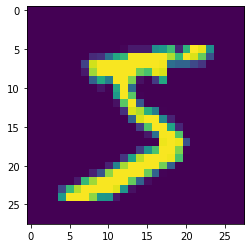

In [15]:
print("Training set: ", x_train.shape)
print("Training time labels:", time_train.shape)
print("Training event labels:", event_train.shape)

print("Testing set: ", x_test.shape)
print("Testing time labels: ", time_test.shape)
print("Testing event labels:", event_test.shape)

plt.imshow(x_train[0])


In [43]:
icc_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', name='conv_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(16, (5, 5), activation='relu', name='conv_2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu', name='dense_1'),
    tf.keras.layers.Dense(84, activation='relu', name='dense_2'),
    tf.keras.layers.Dense(1, activation='linear', name='dense_3')
])

icc_train_fn = InputFunction(train_slices, train_time, train_event,
                  drop_last=True,
                  shuffle=True)

icc_eval_fn = InputFunction(test_slices, test_time, test_event)

icc_trainer = TrainAndEvaluateModel(
    model=icc_model,
    model_dir=Path("ckpts-icc-cnn"),
    train_dataset=icc_train_fn(),
    eval_dataset=icc_eval_fn(),
    learning_rate=0.0003,
    num_epochs=100,
)

In [46]:
# Implementing DeepConvSurv model
dcs_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(7, 7), strides = 3, activation='relu', name='conv_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides = 2, activation='relu', name='conv_2'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides = 2, activation='relu', name='conv_3'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu', name='dense_1'),
    tf.keras.layers.Dense(1, activation='linear', name='dense_3')
])

dcs_train_fn = InputFunction(train_slices, train_time, train_event,
                  drop_last=True,
                  shuffle=True)

dcs_eval_fn = InputFunction(test_slices, test_time, test_event)

dcs_trainer = TrainAndEvaluateModel(
    model=dcs_model,
    model_dir=Path("ckpts-dcs-cnn"),
    train_dataset=dcs_train_fn(),
    eval_dataset=dcs_eval_fn(),
    learning_rate=0.0003,
    num_epochs=100,
)

In [45]:
icc_train_fn = InputFunction(train_slices, train_time, train_event,
                  drop_last=True,
                  shuffle=True)

icc_eval_fn = InputFunction(test_slices, test_time, test_event)

icc_trainer = TrainAndEvaluateModel(
    model=icc_model,
    model_dir=Path("ckpts-icc-cnn"),
    train_dataset=icc_train_fn(),
    eval_dataset=icc_eval_fn(),
    learning_rate=0.0003,
    num_epochs=20,
)

In [28]:
train_fn = InputFunction(x_train, time_train, event_train,
                  drop_last=True,
                  shuffle=True)

eval_fn = InputFunction(x_test, time_test, event_test)

trainer = TrainAndEvaluateModel(
    model=model,
    model_dir=Path("ckpts-mnist-cnn"),
    train_dataset=train_fn(),
    eval_dataset=eval_fn(),
    learning_rate=0.0001,
    num_epochs=15,
)

To obverse training, we can start TensorBoard.

In [19]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [20]:
import os
os.environ['TENSORBOARD_BINARY']='/Users/katyscott/Documents/ICC/venv/bin/tensorboard'

In [47]:
%tensorboard --logdir ckpts-dcs-cnn

Let the training begin…

In [48]:
dcs_trainer.train_and_evaluate()

step 0: mean loss = 9.4300
Validation: loss = 4.0141, cindex = 0.5306
Validation: loss = 3.5590, cindex = 0.4219
Validation: loss = 3.4481, cindex = 0.4328
Validation: loss = 3.3561, cindex = 0.4612
Validation: loss = 3.3702, cindex = 0.4725
Validation: loss = 3.4498, cindex = 0.4864
Validation: loss = 3.3618, cindex = 0.4864
Validation: loss = 3.4035, cindex = 0.4936
Validation: loss = 3.4321, cindex = 0.4989
Validation: loss = 3.4272, cindex = 0.5028
Validation: loss = 3.3957, cindex = 0.5054
Validation: loss = 3.3999, cindex = 0.5026
Validation: loss = 3.4208, cindex = 0.5054
Validation: loss = 3.4427, cindex = 0.5089
Validation: loss = 3.4944, cindex = 0.5072
Validation: loss = 3.5697, cindex = 0.5091
step 200: mean loss = 3.1257
Validation: loss = 3.6654, cindex = 0.5047
Validation: loss = 3.7872, cindex = 0.5083
Validation: loss = 3.7652, cindex = 0.5086
Validation: loss = 3.4490, cindex = 0.5221
Validation: loss = 3.4054, cindex = 0.5050
Validation: loss = 3.3884, cindex = 0.558

In [29]:
icc_trainer.train_and_evaluate()

step 0: mean loss = 3.3499
Validation: loss = 3.5231, cindex = 0.5066
Validation: loss = 3.4955, cindex = 0.5478
Validation: loss = 3.5739, cindex = 0.5192
Validation: loss = 3.6309, cindex = 0.5221
Validation: loss = 3.6001, cindex = 0.5261
Validation: loss = 3.5489, cindex = 0.5386
Validation: loss = 3.5012, cindex = 0.5347
Validation: loss = 3.4770, cindex = 0.5328
Validation: loss = 3.5831, cindex = 0.5550
Validation: loss = 3.6386, cindex = 0.5376
Validation: loss = 3.6438, cindex = 0.5593
Validation: loss = 3.6222, cindex = 0.5534
Validation: loss = 3.6539, cindex = 0.5554
Validation: loss = 3.6961, cindex = 0.5504
Validation: loss = 3.6443, cindex = 0.5579
Validation: loss = 3.6561, cindex = 0.5439
step 200: mean loss = 2.9436
Validation: loss = 3.6632, cindex = 0.5439
Validation: loss = 3.6976, cindex = 0.5408
Validation: loss = 3.7470, cindex = 0.5526
Validation: loss = 3.8454, cindex = 0.5495
Saved checkpoint for step 240: ckpts-icc-cnn/ckpt-1


In [ ]:
trainer.train_and_evaluate()

We can make a couple of observations:

1. The final concordance index on the validation data is close to the optimal value we computed above using the actual underlying risk scores.
2. The loss during training is quite volatile, which stems from the small batch size (64) and the varying number of uncensored samples that contribute to the loss in each batch. Increasing the batch size should yield smoother loss curves.

### Predicting Survival Functions

For inference, things are much easier, we just pass a batch of images and record the predicted risk score. To estimate individual survival functions, we need to estimate the baseline hazard function $h_0$, which can be done analogous to the linear Cox PH model by using [Breslow's estimator](https://www.jstor.org/stable/1402659).

In [ ]:
from sklearn.model_selection import train_test_split
from sksurv.linear_model.coxph import BreslowEstimator


class Predictor:

    def __init__(self, model, model_dir):
        self.model = model
        self.model_dir = model_dir

    def predict(self, dataset):
        ckpt = tf.train.Checkpoint(
            step=tf.Variable(0, dtype=tf.int64),
            optimizer=tf.keras.optimizers.Adam(),
            model=self.model)
        ckpt_manager = tf.train.CheckpointManager(
            ckpt, str(self.model_dir), max_to_keep=2)

        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
            print(f"Latest checkpoint restored from {ckpt_manager.latest_checkpoint}.")

        risk_scores = []
        for batch in dataset:
            pred = self.model(batch, training=False)
            risk_scores.append(pred.numpy())

        return np.row_stack(risk_scores)

In [ ]:
train_pred_fn = tf.data.Dataset.from_tensor_slices(x_train[..., np.newaxis]).batch(64)

predictor = Predictor(model, trainer.model_dir)
train_predictions = predictor.predict(train_pred_fn)

breslow = BreslowEstimator().fit(train_predictions, event_train, time_train)

Once fitted, we can use Breslow's estimator to obtain estimated survival functions for images in the test data. We randomly draw three sample images for each digit and plot their predicted survival function.

In [ ]:
sample = train_test_split(x_test, y_test, event_test, time_test,
                          test_size=30, stratify=y_test, random_state=89)
x_sample, y_sample, event_sample, time_sample = sample[1::2]

sample_pred_ds = tf.data.Dataset.from_tensor_slices(
    x_sample[..., np.newaxis]).batch(64)
sample_predictions = predictor.predict(sample_pred_ds)

sample_surv_fn = breslow.get_survival_function(sample_predictions)

plt.figure(figsize=(6, 4.5))
for surv_fn, class_label in zip(sample_surv_fn, y_sample):
    risk_group = risk_score_assignment.loc[class_label, "risk_group"]
    plt.step(surv_fn.x, surv_fn.y, where="post",
             color=f"C{class_label}", linestyle=styles[risk_group])

plt.ylim(0, 1)
plt.ylabel("Probability of survival $P(T > t)$")
plt.xlabel("Time $t$")
plt.grid()

Solid lines correspond to images that belong to risk group 0 (with lowest risk), which the model was able to learn. Samples from the group with the highest risk are shown as dotted lines. Their predicted survival functions have the steepest descent, confirming that the model correctly identified different risk groups from images.

## Conclusion

We successfully built, trained, and evaluated a convolutional neural network for survival analysis on MNIST. While MNIST is obviously not a clinical dataset, the exact same approach can be used for clinical data. For instance, [Mobadersany et al.](https://www.pnas.org/content/115/13/E2970) used the same approach to predict overall survival of patients diagnosed with brain tumors from microscopic images, and [Zhu et al.](https://scholar.google.com/scholar?cluster=3381426605939025516) applied CNNs to predict survival of lung cancer patients from pathological images.